# Import Data

Notes: spectral clustering, prophet, Sining Chen

In [ ]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
from datetime import datetime
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from pandas.tseries.offsets import DateOffset

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/df_vol1.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/df_vol2.csv")
df = pd.concat([df1, df2])
print(f'df1 shape: {df1.shape}')
print(f'df2 shape: {df2.shape}')
print(f'df shape: {df.shape}')

df1 shape: (40180, 51)
df2 shape: (40178, 51)
df shape: (80358, 51)


In [ ]:
df["launch_date"] = pd.to_datetime(df["launch_date"])
df["date"] = pd.to_datetime(df["date"])
df["start_date"] = pd.to_datetime(df["start_date"])
df["growth_date"] = pd.to_datetime(df["growth_date"])
df["gx_entry_date"] = pd.to_datetime(df["gx_entry_date"])
df['last_ind_days'] = pd.to_timedelta(df["last_ind_days"]).dt.days
df.regulatory_designations_hasany = df.regulatory_designations_hasany.fillna(0)
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df.growth_change_rate = df.growth_change_rate.fillna(np.mean(df.growth_change_rate))

df = df.assign(
    x1 = lambda x: 100* x.vol_std_before_2016 / x.vol_mean_before_2016 ,
    x2 = lambda x: 100* (x.vol_std_before_4m - x.vol_std_before_1y)/x.vol_std_before_1y ,
    x3 = lambda x: 100*(x.vol_mean_before_4m - x.vol_mean_before_1y) / x.vol_mean_before_1y,
    x4 = lambda x: 100*(x.vol_std_before_4m - x.vol_std_before_2016) / x.vol_std_before_2016,
    )
df.x1 = df.x1.fillna(0)
df.x2 = df.x2.fillna(0)
df.x3 = df.x3.fillna(0)
df.x4 = df.x4.fillna(0)

In [ ]:
benchmark = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/benchmark_anon.csv")
benchmark = benchmark.drop(columns = {benchmark.columns[0]})
benchmark["date"] = pd.to_datetime(benchmark["date"])

validation_2 = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/submission_part_two.csv")
validation_2 = validation_2.drop(columns = {validation_2.columns[0]})

sub_2 = validation_2.copy()
sub_2['volume'] = sub_2.volume.where(~sub_2.volume.notna(), pd.NaT)
sub_2["date"] = pd.to_datetime(sub_2["date"])


print(f'benchmark shape: {benchmark.shape}')
print(f'sub_2 shape: {sub_2.shape}')

benchmark shape: (8362, 3)
sub_2 shape: (8362, 3)


In [ ]:
print(len(df.cluster_id.unique()))
df.columns

878


Index(['country', 'cluster', 'cluster_id', 'date', 'stage_name',
       'stage_name_lag_1', 'volume', 'business_unit', 'ther_area_fact',
       'prevalence', 'gx_entry_date', 'launch_date', 'start_date',
       'transition_point', 'launch_months', 'time_since_no_exclusivity',
       'year', 'population', 'regulatory_designations_hasany',
       'indication_num', 'comp_num', 'first_comp_month', 'is_exclusive',
       'last_stage_days', 'last_ind_days', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', '10', '11', '12', 'vol_mean_alltime', 'vol_std_alltime',
       'vol_mean_before_2016', 'vol_std_before_2016', 'vol_mean_before_4m',
       'vol_std_before_4m', 'vol_mean_before_1y', 'vol_std_before_1y',
       'growth_date', 'month_since_growth', 'volume_lag_1m_pctg',
       'month_since_GtoM_trans', 'vol_standard', 'growth_change_rate', 'month',
       'x1', 'x2', 'x3', 'x4'],
      dtype='object')

# Train Set Split (Zehui)

In [ ]:
def train_val_split(df, keep_stage='Maturity'):

  ''' 
  description: Extract train, val from df by cluster id randomly
  input: df - the dataframe with features and labels for regression task
         keep_stage - 'Maturity', 'Growth', 'All'
  output: train, val
  '''
  random.seed(0)
  
  clusterID_withTP = df.query('stage_name!="Growth" & date<="2019-03-01"').cluster_id.unique() # len=367

  trainID = random.sample(set(clusterID_withTP), k=int(0.7*len(clusterID_withTP))) # len=293
  val_test_ID = list(set(clusterID_withTP)-set(trainID)) # len=74
  valID = random.sample(set(val_test_ID), k=int(0.666*len(val_test_ID)))
  testID = list(set(val_test_ID)-set(valID)) # len=74

  if keep_stage=='Maturity':
    train_df = df[(df['cluster_id'].isin(trainID)) & (df['date']<="2019-03-01")&(df['stage_name']=="Maturity")]
    val_df = df[(df['cluster_id'].isin(valID)) & (df['date']<="2019-03-01")&(df['stage_name']=="Maturity")]
    test_df = df[(df['cluster_id'].isin(testID)) & (df['date']<="2019-03-01")&(df['stage_name']=="Maturity")]
  elif keep_stage=='Growth':
    train_df = df[(df['cluster_id'].isin(trainID)) & (df['date']<="2019-03-01")&(df['stage_name']=="Growth")]
    val_df = df[(df['cluster_id'].isin(valID)) & (df['date']<="2019-03-01")&(df['stage_name']=="Growth")]
    test_df = df[(df['cluster_id'].isin(testID)) & (df['date']<="2019-03-01")&(df['stage_name']=="Maturity")]
  else:
    train_df = df[(df['cluster_id'].isin(trainID)) & (df['date']<="2019-03-01")]
    val_df = df[(df['cluster_id'].isin(valID)) & (df['date']<="2019-03-01")]
    test_df = df[(df['cluster_id'].isin(testID)) & (df['date']<="2019-03-01")&(df['stage_name']=="Maturity")]
  return train_df, val_df, test_df

train_df, val_df, test_df = train_val_split(df, keep_stage='Maturity')
print(len(train_df.cluster_id.unique()))
print(len(val_df.cluster_id.unique()))
print(len(test_df.cluster_id.unique()))

328
93
48


# Regression Model (Jason)

### Data Split

#### Change Rate feature function



In [ ]:
import math

def change_rate(df):

    copy = df.copy()
    l = len(copy)

    for i in range(l):
        current_row = copy.loc[i,:]

        try:
            prev_row = copy.loc[i-1,:]

            if prev_row.cluster_id == current_row.cluster_id and current_row.volume != -1.0:
                df.at[i,'change_rate'] = math.log(current_row.volume / prev_row.volume)
            else:
                df.at[i,'change_rate'] = np.NaT
        except:
            continue

    return df

In [ ]:
df.reset_index(drop=True,inplace=True)
df = change_rate(df) # takes time, could be improved later

#### Train-val split

In [ ]:
train_df,val_df,test_df = train_val_split(df, keep_stage='Maturity')

# filter out average change rate larger than 0
train_df_desc = train_df.groupby("cluster_id").mean()['change_rate'].reset_index()
train_df_desc_cluster = list(train_df_desc[train_df_desc["change_rate"] <= 0].cluster_id)
train_df = train_df[train_df.cluster_id.isin(train_df_desc_cluster)]
print(f'training cluster_id number: {len(train_df_desc_cluster)}')

training cluster_id number: 121


In [ ]:
#Run this chunk to use change rate as label
drop = ["date","stage_name_lag_1","stage_id_cumsum","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month', 
         'last_ind_days', 'vol_standard','volume',
         'population','prevalence','prevalence_pct', 
         '1','2','3','4','5','6','7','8','9','10','11','12']
drop = set(df.columns).intersection(drop) # Hang Added this line, contact me if have question

training_set = train_df.drop(drop,axis=1)
val_set = val_df.drop(drop, axis=1)
test_set = test_df.drop(drop, axis=1)

x_train = training_set.drop(["change_rate"],axis=1)
y_train = training_set.change_rate

x_val = val_set.drop(["change_rate"],axis=1)
y_val = val_set.change_rate

x_test = test_set.drop(["change_rate"],axis=1)
y_test = test_set.change_rate

### Random Forest Regressor

#### RF Training

In [ ]:
c_feature = ['country','cluster','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany","year"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months',
             'month_since_growth','x1','x2','x3','x4','vol_mean_alltime','vol_std_alltime',
             'month_since_GtoM_trans','growth_change_rate']

c_feature = ['country','cluster','cluster_id','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth','x1','x2','x3','x4']

In [ ]:
preprocess1 = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),c_feature),
                                      (StandardScaler(),n_feature))

rfr_pipe1 = make_pipeline(preprocess1, RandomForestRegressor(
                                  n_estimators = 50,
                                  random_state = 0,
                                  oob_score=True, 
                                  warm_start=True,
                                  n_jobs=-1))

rfr_pipe1.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'cluster',
                                                   'business_unit',
                                                   'ther_area_fact',
                                                   'is_exclusive', 'month',
                                                   'regulatory_designations_hasany',
                                                   'year']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['indication_num', 'comp_num',
                                                   'first_comp_month',
                                                   'launch_months',
                 

#### RF Result

In [ ]:
pred1_val = rfr_pipe1.predict(x_val)
#pred1_val = ss.inverse_transform(np.array(pred1_val).reshape(-1,1))
print("x_val MSE:",mean_squared_error(y_val,pred1_val))

pred1_test = rfr_pipe1.predict(x_test)
#pred1_test = ss.inverse_transform(np.array(pred1_test).reshape(-1,1))
print("x_test MSE:",mean_squared_error(y_test,pred1_test))

print(f'prediction mean change rate: {np.mean(pred1_test)}')

x_val MSE: 0.24300335489270555
x_test MSE: 0.2822611590314087
prediction mean change rate: -0.008701991257758957


In [ ]:
def visualize_pred(test_set, pred, no_cluster=10):
    '''
    Input: test_set, prediction list, number of clusters to show
    '''

    cluster_ids = list(test_set.cluster_id.unique())

    vis_test_set = test_set.copy()
    vis_test_set['predicted_vol'] = pred

    fig,axes = plt.subplots(int(no_cluster/2),2,figsize=(20,no_cluster * 1.6))

    for i in range(no_cluster):
        id = cluster_ids[i]
        tgt = vis_test_set[vis_test_set.cluster_id == id]
        sns.lineplot(x='date',y='change_rate',data=tgt,ax=axes.flatten()[i],label="Actual") # change rate here
        sns.lineplot(x='date',y='predicted_vol',data=tgt,ax=axes.flatten()[i],label="Prediction")

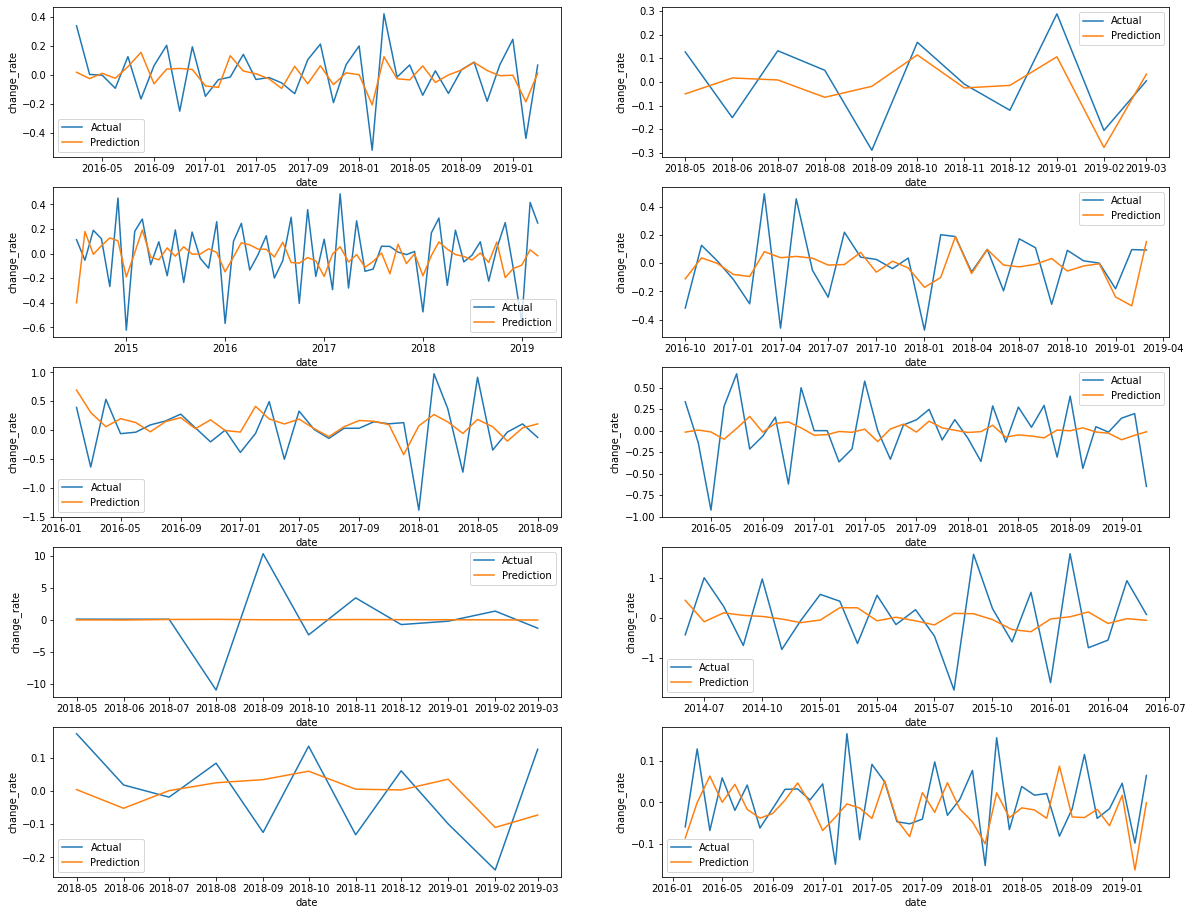

In [ ]:
visualize_pred(test_df,pred1_test)

# RNN model (no stage involved) (Zehui)

In [ ]:
INPUT_LENGTH = 18

random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
# prepocess and choose features
df_rnn = df.copy()
df_rnn['country'] = df_rnn['country'].apply(lambda x: float(x[-1]))
df_rnn['business_unit'] = df_rnn['business_unit'].apply(lambda x: 1.0 if x=='ONE' else 2.0)
df_rnn['is_exclusive'] = df_rnn['is_exclusive'].apply(lambda x: 1.0 if x=='True' else 0.0)
df_rnn = df_rnn[['ther_area_fact','time_since_no_exclusivity','regulatory_designations_hasany',
                 'indication_num','comp_num','is_exclusive', 'country', 'business_unit', 'change_rate','cluster_id','date','stage_name','month_since_growth']]

In [ ]:
# train val split
def train_val_split_rnn(df_rnn, input_length):
  ''' 
  description: use windows of length=input_length to extract input and output, then randomly choose train/val set.
  input: df_rnn - the dataframe with features and labels for regression task
         input_length - windows size
  output: train_data, val_data
  '''
  random.seed(0) 
  clusterID = df_rnn.query('stage_name!="Growth" & date<="2019-03-01"').cluster_id.unique()

  data = []
  for id in clusterID:
    df_rnn_sub = df_rnn[df_rnn['cluster_id']==id].query('date<="2019-03-01"').reset_index(drop=True)
    if len(df_rnn_sub)>=input_length+2:
      for i in range(1, len(df_rnn_sub)-input_length):
        x = df_rnn_sub.loc[i:i+input_length-1, ~df_rnn_sub.columns.isin(['cluster_id','date','stage_name'])].values
        y = df_rnn_sub.loc[i+input_length,'change_rate']
        data.append(tuple([x,y]))
  train_data, val_data = train_test_split(data, train_size=0.8, random_state=0)
  return train_data, val_data

In [ ]:
class dataset(Dataset):
   # dataset
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)   

    def __getitem__(self,idx):
        return torch.tensor(self.data[idx][0], dtype=torch.float32), torch.tensor(self.data[idx][1], dtype=torch.float32)

In [ ]:
train_data, val_data = train_val_split_rnn(df_rnn, input_length=INPUT_LENGTH)
print(len(train_data))
print(len(val_data))

16480
4121


In [ ]:
train_dataset = dataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = dataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.bn = torch.nn.BatchNorm1d(num_features=10)
        self.RNN = torch.nn.LSTM(10,5,num_layers = 1,dropout = 0,batch_first=True,bidirectional=True)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(5,1) 
        )
        
    def forward(self, x):
    
        x = self.bn(x.permute(0,2,1)) # Batch,Feature,Time 
        
        x = x.permute(0,2,1) #  Batch,Time,Feature
        
        output,(hn,cn) = self.RNN(x)#  Time, Batch,Feature

        output = self.fc(torch.mean(hn, 0))
        
        return output

In [ ]:
def train(Model,device,train_loader,optimizer,loss_fn = torch.nn.L1Loss()): 
    Model.train()    
    train_loss = 0 
    for (X,y) in train_loader:
        X = X.to(device)
        y = y.to(device)        
        
        Model.zero_grad()
        pred = Model(X)
        loss = loss_fn(pred,y.unsqueeze(1))
        train_loss += loss.item() * X.size(0)
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_loader.dataset)
    return train_loss    

def test(Model, device, test_loader,loss_fn = torch.nn.L1Loss()):
    Model.eval()
    test_loss = 0
    with torch.no_grad():
        for (X, y) in test_loader:
            X = X.to(device)
            y = y.to(device)
            
            pred = Model(X)
            loss = loss_fn(pred, y.unsqueeze(1))
            test_loss += loss.item()*X.shape[0]  # sum up batch loss
    test_loss /= len(test_loader.dataset)
    return test_loss

In [ ]:


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

N_EPOCHS, LEARNING_RATE = 50, 0.002
model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


train_losses = []
valid_losses = []
best_loss = 1000

for epoch in range(N_EPOCHS):
    # training
    train_loss = train(model, device, train_loader, optimizer)
    train_losses.append(train_loss)
    
    # validating
    with torch.no_grad():
        valid_loss = test(model, device, val_loader)
        valid_losses.append(valid_loss)
    
    if valid_loss < best_loss:
      torch.save(model.state_dict(), 'checkpoint.pth')
      best_loss = valid_loss
    print(f'Epoch: {epoch} Train loss: {train_loss:.4f} Valid loss: {valid_loss:.4f}')

Epoch: 0 Train loss: 0.2450 Valid loss: 0.2200
Epoch: 1 Train loss: 0.2091 Valid loss: 0.2030
Epoch: 2 Train loss: 0.1992 Valid loss: 0.1982
Epoch: 3 Train loss: 0.1953 Valid loss: 0.1962
Epoch: 4 Train loss: 0.1933 Valid loss: 0.1944
Epoch: 5 Train loss: 0.1923 Valid loss: 0.1932
Epoch: 6 Train loss: 0.1916 Valid loss: 0.1958
Epoch: 7 Train loss: 0.1908 Valid loss: 0.1922
Epoch: 8 Train loss: 0.1899 Valid loss: 0.1919
Epoch: 9 Train loss: 0.1894 Valid loss: 0.1909
Epoch: 10 Train loss: 0.1897 Valid loss: 0.1910
Epoch: 11 Train loss: 0.1886 Valid loss: 0.1907
Epoch: 12 Train loss: 0.1887 Valid loss: 0.1910
Epoch: 13 Train loss: 0.1883 Valid loss: 0.1903
Epoch: 14 Train loss: 0.1885 Valid loss: 0.1910
Epoch: 15 Train loss: 0.1877 Valid loss: 0.1897
Epoch: 16 Train loss: 0.1885 Valid loss: 0.1915
Epoch: 17 Train loss: 0.1882 Valid loss: 0.1905
Epoch: 18 Train loss: 0.1882 Valid loss: 0.1896
Epoch: 19 Train loss: 0.1872 Valid loss: 0.1898
Epoch: 20 Train loss: 0.1872 Valid loss: 0.1904
Ep

In [ ]:
model.load_state_dict(torch.load('checkpoint.pth'))
test(model, device, val_loader)

0.18834145213830994

In [ ]:
ids = validation_2.cluster_id.unique()
prediction = validation_2.copy()
prediction = prediction[['cluster_id','date']]
prediction['change_rate'] = 0.0
prediction['date'] = pd.to_datetime(prediction['date'])
input_length = INPUT_LENGTH
for id in ids:
  df_rnn_sub = df_rnn[df_rnn['cluster_id']==id].query('date>="2018-11-01"').reset_index(drop=True)
  for i in range(len(df_rnn_sub)-input_length):
    x = df_rnn_sub.loc[i:i+input_length-1, ~df_rnn_sub.columns.isin(['cluster_id','date','stage_name'])].values
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
    y = model(x).item()
    df_rnn_sub.loc[i+input_length,'change_rate'] = y
    date = df_rnn_sub.loc[i+input_length,'date']
    prediction.loc[(prediction.cluster_id==id) & (prediction.date==date),'change_rate'] = y

In [ ]:
# calculate volume from change rate
df_prediction = prediction.merge(df.query('date=="2019-03-01"')[['cluster_id','volume']], on='cluster_id', how='inner').reset_index()
df_prediction['date'] = pd.to_datetime(df_prediction['date'])
#df_prediction.loc[0,"volume"]=0
df_prediction

for i in range(len(df_prediction)):
  if df_prediction.iloc[i,:]['date'] == pd.to_datetime("2019-04-01"):
    df_prediction.loc[i,'volume']= np.exp(df_prediction.loc[i,'change_rate'])*df_prediction.loc[i,'volume']
    # print(np.exp(df_prediction.loc[i,'change_rate'])*df_prediction.loc[i,'volume'])
    # print(df_prediction.loc[i,'volume'])
  else:
    df_prediction.loc[i,'volume']= np.exp(df_prediction.loc[i,'change_rate'])*df_prediction.loc[i-1,'volume']
  
df_prediction

index cluster_id       date  change_rate        volume
0         0      ID_35 2019-04-01          0.0  3.362386e+10
1         1      ID_35 2019-05-01          0.0  3.362386e+10
2         2      ID_35 2019-06-01          0.0  3.362386e+10
3         3      ID_35 2019-07-01          0.0  3.362386e+10
4         4      ID_35 2019-08-01          0.0  3.362386e+10
...     ...        ...        ...          ...           ...
8357   8357    ID_3218 2021-12-01          NaN           NaN
8358   8358    ID_3218 2022-01-01          NaN           NaN
8359   8359    ID_3218 2022-02-01          NaN           NaN
8360   8360    ID_3218 2022-03-01          NaN           NaN
8361   8361    ID_3218 2022-04-01          NaN           NaN

[8362 rows x 5 columns]

# benchmark + diff model (Shuyue & Lindsey)

## Benchmark Functions

### generate benchmark slope(Shuyue)

In [ ]:
def benchmark_18months(train_dfmix,df):
  ##input should be the datasets which we need to get the benchmark
  ## would return a dataframe contains the cluster_id, slope, and the transition date
  idswithtrainsition = train_dfmix[train_dfmix['transition_point'] == 1].cluster_id.unique()
  clusternumber = len(idswithtrainsition)
  dict = {'cluster_id':[],
        'date':[],
        'slope':[],
        'volume':[]
       }
  benchmarkpd = pd.DataFrame(dict)

  for j in range(clusternumber):
    temp =df[df['cluster_id']==idswithtrainsition[j]]
    q = len(temp)
    f = []
    l = []
    for i in range(q):
        current_row = temp.iloc[i,:]
        try:
          if (current_row.stage_name == 'Growth' )& (len(f) == 0):
            f.append(current_row.volume)
            sd =  current_row.date
          if (current_row.stage_name == 'Maturity') & (current_row.stage_name_lag_1 == 'Growth' )&(len(l) == 0):
            l.append(current_row.volume)
            ed = current_row.date
          if((len(f) != 0 )& (len(l) !=0)):
            break

        except:
            continue
    sd2 =  ed - pd.DateOffset(months = 18) 
    if(sd2 >= sd):
      slope = (l[0] -float(temp[temp.date == sd2].volume))/24
    else:
      slope = (l[0]-f[0])/((ed.year - sd.year) * 12 + (ed.month - sd.month))

    if (slope < 0):
      slope = 0

    benchmarkpd.loc[len(benchmarkpd.index)] = [idswithtrainsition[j], ed, slope,l[0]] 
  
  return benchmarkpd

In [ ]:
def benchmark_firstlast(train_dfmix,df):
  ##input should be the datasets which we need to get the benchmark
  ## would return a dataframe contains the cluster_id, slope, and the transition date
  idswithtrainsition = train_dfmix[train_dfmix['transition_point'] == 1].cluster_id.unique()
  clusternumber = len(idswithtrainsition)
  dict = {'cluster_id':[],
        'date':[],
        'slope':[],
        'volume':[]
       }
  benchmarkpd = pd.DataFrame(dict)

  for j in range(clusternumber):
    temp =df[df['cluster_id']==idswithtrainsition[j]]
    q = len(temp)
    f = []
    l = []
    for i in range(q):
        current_row = temp.iloc[i,:]
        try:
          if (current_row.stage_name == 'Growth' )& (len(f) == 0):
            f.append(current_row.volume)
            sd =  current_row.date
          if (current_row.stage_name == 'Maturity') & (current_row.stage_name_lag_1 == 'Growth' )&(len(l) == 0):
            l.append(current_row.volume)
            ed = current_row.date
          if((len(f) != 0 )& (len(l) !=0)):
            break

        except:
            continue
    
    slope = (l[0]-f[0])/((ed.year - sd.year) * 12 + (ed.month - sd.month))
    if (slope < 0):
      slope = 0
    benchmarkpd.loc[len(benchmarkpd.index)] = [idswithtrainsition[j], ed, slope,l[0]] 
  
  return benchmarkpd

### using benchmark slope to get the benchmark volume(shuyue)

In [ ]:
def benchmarkwhole(benchmarkslop):
  dict = {
          'date':[],
        'benchmarkvolume':[],
        'cluster_id':[]
       }
  result = pd.DataFrame(dict)    
  for i in range(len(benchmarkslop)):
      temp = benchmarkslop.iloc[i]
      date = temp.date
      slope = temp.slope
      cluster_id = temp.cluster_id
      end = pd.to_datetime('2022-04-01')
      volume = float(temp.volume)

      f = pd.DataFrame(pd.date_range(start=date, end = end, freq='MS',name = 'date'))
      f['benchmarkvolume'] = volume + ((f['date'].dt.year-date.year)*12+(f['date'].dt.month - date.month))*slope
      f['cluster_id'] = cluster_id 
      result = result.append(f)

  return result

### create benchmark for data after 2019(shuyue)

In [ ]:
def benchmark_func(sub_2,df):
  ##input should be the datasets which we need to get the benchmark
  ## would return a dataframe contains the cluster_id, slope, and the transition date
  idswithtrainsition = sub_2.cluster_id.unique()
  clusternumber = len(idswithtrainsition)
  dict = {'cluster_id':[],
        'date':[],
        'slope':[],
        'volume':[]
       }
  benchmarkpd = pd.DataFrame(dict)

  for j in range(clusternumber):
    temp =df[df['cluster_id']==idswithtrainsition[j]]
    ed = pd.to_datetime('2019-03-01')
    sd =  ed - pd.DateOffset(months = 18)
    if(temp.iloc[0].date >= sd):
      slope = (float(temp[temp.date == ed].volume) - float(temp.iloc[0].volume))/((ed.year - temp.iloc[0].date.year) * 12 + (ed.month - temp.iloc[0].date.month))
    else:
      slope = (float(temp[temp.date == ed].volume) -float(temp[temp.date == sd].volume))/24

    if (slope < 0):
      slope = 0

    benchmarkpd.loc[len(benchmarkpd.index)] = [idswithtrainsition[j], ed, slope,float(temp[temp.date == ed].volume)] 
  
  return benchmarkpd

## Execution

In [ ]:
benchmarksub2slope = benchmark_func(sub_2,df)
benchmark = benchmarkwhole(benchmarksub2slope)

Growth: Green
Mature: blue
Actural: balck
Predicted: red


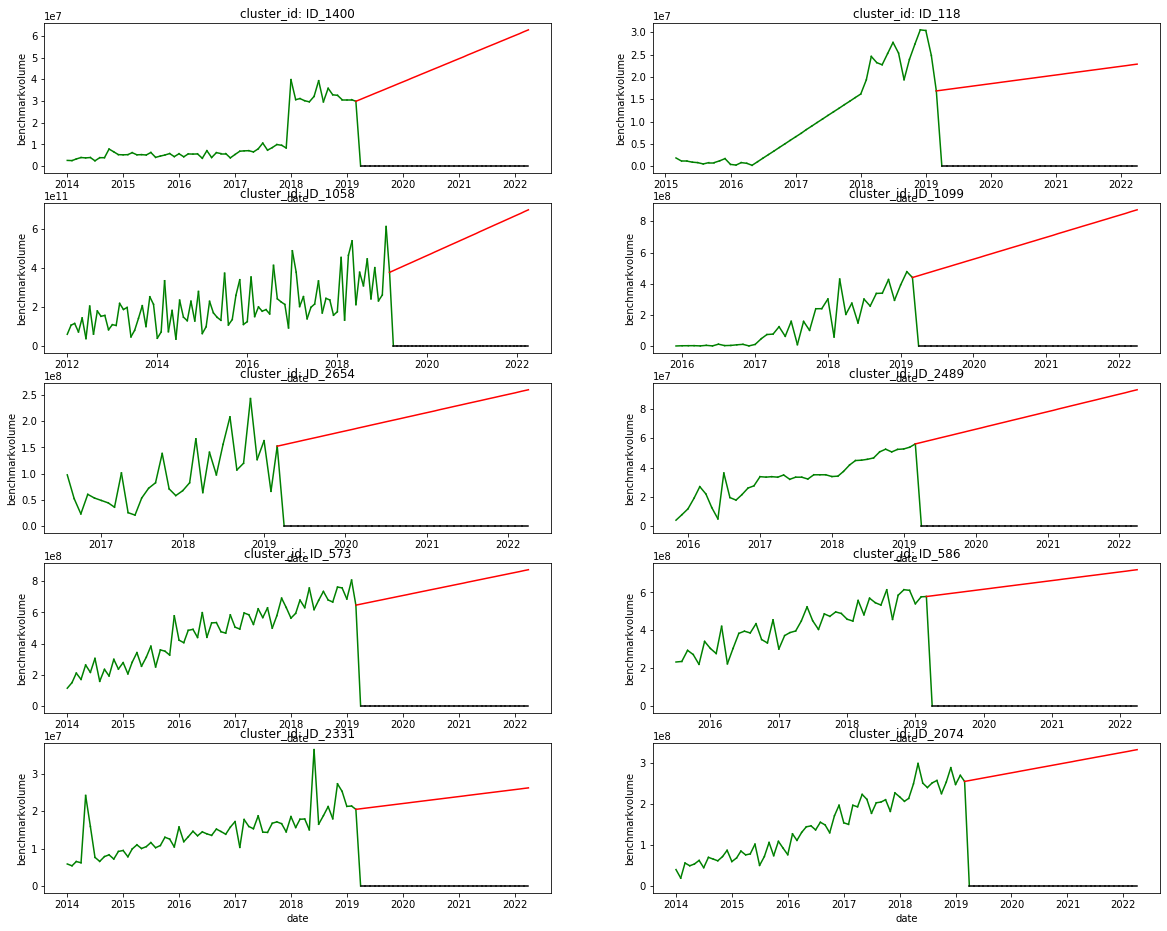

In [ ]:
ids =sub_2.cluster_id.unique()
fig,axes = plt.subplots(5,2,figsize=(20,16))
print("Growth: Green")
print("Mature: blue")
print("Actural: balck")
print("Predicted: red")
for i in range(10):
    rand = random.randint(0,len(ids))
    cluster = df[df['cluster_id']==ids[rand]].iloc[:,:].reset_index()
    axes.flatten()[i].title.set_text(f'cluster_id: {ids[rand]}')
    predicted = benchmark[benchmark['cluster_id']==ids[rand]].iloc[:,:]


    # cluster = final_df[final_df['cluster_id']=='ID_40'].iloc[:,[2,3,4,7]].reset_index()
    # axes.flatten()[i].title.set_text(f'cluster_id: ID_40')
    # predicted = benchmark[benchmark['cluster_id']=='ID_40'].iloc[:,[1,2]]

    for idx, row in cluster.iterrows():
      if idx==len(cluster)-1:
          break    
      if row.stage_name =='Growth':
          color = 'green'
      elif row.stage_name =='Maturity':
          color = 'blue'
      else:
          color = 'black' # Stage Name missing
      sns.lineplot(x=[row.date, cluster.loc[idx + 1, 'date']], y=[row.volume, cluster.loc[idx + 1, 'volume']], color=color, ax=axes.flatten()[i])

    sns.lineplot(x='date',y='benchmarkvolume',data=predicted,color='red',ax=axes.flatten()[i])

### create benchmarks functions(shuyue)



In [ ]:
benchmark

date  benchmarkvolume cluster_id
0  2019-03-01     3.362386e+10      ID_35
1  2019-04-01     3.441969e+10      ID_35
2  2019-05-01     3.521552e+10      ID_35
3  2019-06-01     3.601135e+10      ID_35
4  2019-07-01     3.680718e+10      ID_35
..        ...              ...        ...
33 2021-12-01     9.868633e+06    ID_3218
34 2022-01-01     9.996496e+06    ID_3218
35 2022-02-01     1.012436e+07    ID_3218
36 2022-03-01     1.025222e+07    ID_3218
37 2022-04-01     1.038008e+07    ID_3218

[8588 rows x 3 columns]

In [ ]:
# benchmark['slope'] = benchmark['forecast']-benchmark.groupby(['cluster_id']).shift(1)['forecast']
# benchmarkslope =  pd.DataFrame(benchmark.groupby(by=["cluster_id"])['slope'].mean()).reset_index()
train_dfmix, val_dfmix, test_dfmix = train_val_split(df,'All')
# benchmark[benchmark['cluster_id'] == 'ID_502']

In [ ]:
# benchmarkslope

In [ ]:
len(train_dfmix.cluster_id.unique())

328

In [ ]:
# benchmarkslope[benchmarkslope['cluster_id'].isin(train_dfmix.cluster_id.unique())] 

- use the first volume and the last volume before transition to calculate the slope:


In [ ]:
topredictid = df[(df['date']=='2019-03-01') & (df['stage_name']=='Growth')].cluster_id.unique()
# benchmarkslopemean =benchmarkslope[benchmarkslope['cluster_id'].isin(topredictid)] 

In [ ]:
# clusternumber = len(topredictid )
# dict = {'cluster_id':[],
#         'slope':[]
#        }
# test = pd.DataFrame(dict)

# for j in range(clusternumber):
#     temp =df[df['cluster_id']==topredictid[j]]
#     ed = pd.to_datetime('2019-03-01')
#     slope = (float(temp[temp.date == ed].volume) - temp.iloc[0].volume)/((ed.year - temp.iloc[0].date.year) * 12 + (ed.month - temp.iloc[0].date.month))
#     test.loc[len(test.index)] = [topredictid[j],slope] 

In [ ]:
# vol1 = benchmarkwhole(test)

In [ ]:
# ##compare given benchmark and the calculated benchmark 
# test = test.merge(benchmarkslope, on = ['cluster_id'], how = 'left')
# np.mean(abs(test ['slope_x'] - test['slope_y']))


In [ ]:
# test

In [ ]:
# def benchmark_firstlast(train_dfmix,df):
#   ##input should be the datasets which we need to get the benchmark
#   ## would return a dataframe contains the cluster_id, slope, and the transition date
#   idswithtrainsition = train_dfmix[train_dfmix['transition_point'] == 1].cluster_id.unique()
#   clusternumber = len(idswithtrainsition)
#   dict = {'cluster_id':[],
#         'date':[],
#         'slope':[],
#         'volume':[]
#        }
#   benchmarkpd = pd.DataFrame(dict)

#   for j in range(clusternumber):
#     temp =df[df['cluster_id']==idswithtrainsition[j]]
#     q = len(temp)
#     f = []
#     l = []
#     for i in range(q):
#         current_row = temp.iloc[i,:]
#         try:
#           if (current_row.stage_name == 'Growth' )& (len(f) == 0):
#             f.append(current_row.volume)
#             sd =  current_row.date
#           if (current_row.stage_name == 'Maturity') & (current_row.stage_name_lag_1 == 'Growth' )&(len(l) == 0):
#             l.append(current_row.volume)
#             ed = current_row.date
#           if((len(f) != 0 )& (len(l) !=0)):
#             break

#         except:
#             continue
    
#     slope = (l[0]-f[0])/((ed.year - sd.year) * 12 + (ed.month - sd.month))
#     benchmarkpd.loc[len(benchmarkpd.index)] = [idswithtrainsition[j], ed, slope,l[0]] 
  
#   return benchmarkpd



- use the last point and two years before the last point

In [ ]:
# dict = {'cluster_id':[],
#         'slope':[]
#        }
# test2 = pd.DataFrame(dict)

# for j in range(clusternumber):
#     temp =df[df['cluster_id']==topredictid[j]].reset_index()
#     ed = pd.to_datetime('2019-03-01')
#     sd =  ed - pd.DateOffset(years=2)
#     if(temp.iloc[0].date >= sd):
#       slope = (float(temp[temp.date == ed].volume) - float(temp.iloc[0].volume))/((ed.year - temp.iloc[0].date.year) * 12 + (ed.month - temp.iloc[0].date.month))
#     else:
#       slope = float(temp[temp.date == ed].volume) -float(temp[temp.date == sd].volume)/24
   
#     test2.loc[len(test2.index)] = [topredictid[j],slope] 

In [ ]:
# ##compare given benchmark and the calculated benchmark 
# test2 = test2.merge(benchmarkslope, on = ['cluster_id'], how = 'left')
# np.mean(abs(test2 ['slope_x'] - test2['slope_y']))


In [ ]:
# test2

- use the last point and one year before the last point

In [ ]:
# dict = {'cluster_id':[],
#         'slope':[]
#        }
# test3 = pd.DataFrame(dict)

# for j in range(clusternumber):
#     temp =df[df['cluster_id']==topredictid[j]].reset_index()
#     ed = pd.to_datetime('2019-03-01')
#     sd =  ed - pd.DateOffset(years=1)
#     if(temp.iloc[0].date >= sd):
#       slope = (float(temp[temp.date == ed].volume) - float(temp.iloc[0].volume))/((ed.year - temp.iloc[0].date.year) * 12 + (ed.month - temp.iloc[0].date.month))
#     else:
#       slope = float(temp[temp.date == ed].volume) -float(temp[temp.date == sd].volume)/24
   
#     test3.loc[len(test3.index)] = [topredictid[j],slope] 

In [ ]:
# ##compare given benchmark and the calculated benchmark 
# test3 = test3.merge(benchmarkslope, on = ['cluster_id'], how = 'left')
# np.mean(abs(test3 ['slope_x'] - test3['slope_y']))


In [ ]:

# test3

- 18months diff

In [ ]:
# dict = {'cluster_id':[],
#         'slope':[]
#        }
# test4 = pd.DataFrame(dict)

# for j in range(clusternumber):
#     temp =df[df['cluster_id']==topredictid[j]].reset_index()
#     ed = pd.to_datetime('2019-03-01')
#     sd =  ed - pd.DateOffset(months = 18)
#     if(temp.iloc[0].date >= sd):
#       slope = (float(temp[temp.date == ed].volume) - float(temp.iloc[0].volume))/((ed.year - temp.iloc[0].date.year) * 12 + (ed.month - temp.iloc[0].date.month))
#     else:
#       slope = float(temp[temp.date == ed].volume) -float(temp[temp.date == sd].volume)/24
   
#     test4.loc[len(test4.index)] = [topredictid[j],slope] 

In [ ]:
##compare given benchmark and the calculated benchmark 
# test4 = test4.merge(benchmarkslope, on = ['cluster_id'], how = 'left')
# np.mean(abs(test4 ['slope_x'] - test4['slope_y']))


In [ ]:
# test4

### make benchmark dataframe & check benchmarks & make diffs(shuyue)


In [ ]:
m_train_df,m_val_df,m_test_df = train_val_split(df, keep_stage='Maturity')

In [ ]:
benchmarkslop18 = benchmark_18months(m_train_df,df)

In [ ]:
benchmarkslop = benchmark_firstlast(m_train_df,df)

In [ ]:
benchmarkslop

cluster_id       date         slope        volume
0        ID_18 2014-02-01  1.333189e+09  6.128264e+10
1        ID_23 2014-02-01  1.853165e+06  8.348956e+07
2        ID_43 2016-03-01  6.625563e+08  7.322991e+09
3        ID_45 2018-05-01  3.775858e+07  1.685450e+09
4        ID_60 2016-05-01  0.000000e+00  2.259898e+10
..         ...        ...           ...           ...
323     ID_763 2014-02-01  1.463004e+08  8.001156e+09
324     ID_764 2016-03-01  1.510695e+08  1.384892e+10
325     ID_766 2014-02-01  4.059029e+05  1.300204e+07
326     ID_772 2015-11-01  1.896007e+05  5.362721e+06
327     ID_780 2018-10-01  3.352738e+07  2.244555e+09

[328 rows x 4 columns]

In [ ]:
def benchmarkwhole(benchmarkslop):
  dict = {
          'date':[],
        'benchmarkvolume':[],
        'cluster_id':[]
       }
  result = pd.DataFrame(dict)    
  for i in range(len(benchmarkslop)):
      temp = benchmarkslop.iloc[i]
      date = temp.date
      slope = temp.slope
      cluster_id = temp.cluster_id
      end = pd.to_datetime('2022-04-01')
      volume = float(temp.volume)

      f = pd.DataFrame(pd.date_range(start=date, end = end, freq='MS',name = 'date'))
      f['benchmarkvolume'] = volume + ((f['date'].dt.year-date.year)*12+(f['date'].dt.month - date.month))*slope
      f['cluster_id'] = cluster_id 
      result = result.append(f)

  return result


In [ ]:
benchmarkgenerate = benchmarkwhole(benchmarkslop)

In [ ]:
benchmarkgenerate

date  benchmarkvolume cluster_id
0  2014-02-01     6.128264e+10      ID_18
1  2014-03-01     6.261583e+10      ID_18
2  2014-04-01     6.394902e+10      ID_18
3  2014-05-01     6.528221e+10      ID_18
4  2014-06-01     6.661539e+10      ID_18
..        ...              ...        ...
38 2021-12-01     3.518595e+09     ID_780
39 2022-01-01     3.552123e+09     ID_780
40 2022-02-01     3.585650e+09     ID_780
41 2022-03-01     3.619177e+09     ID_780
42 2022-04-01     3.652705e+09     ID_780

[25204 rows x 3 columns]

In [ ]:
benchmarkgenerate18 = benchmarkwhole(benchmarkslop18)

Growth: Green
Mature: blue
Actural: balck
Predicted: red


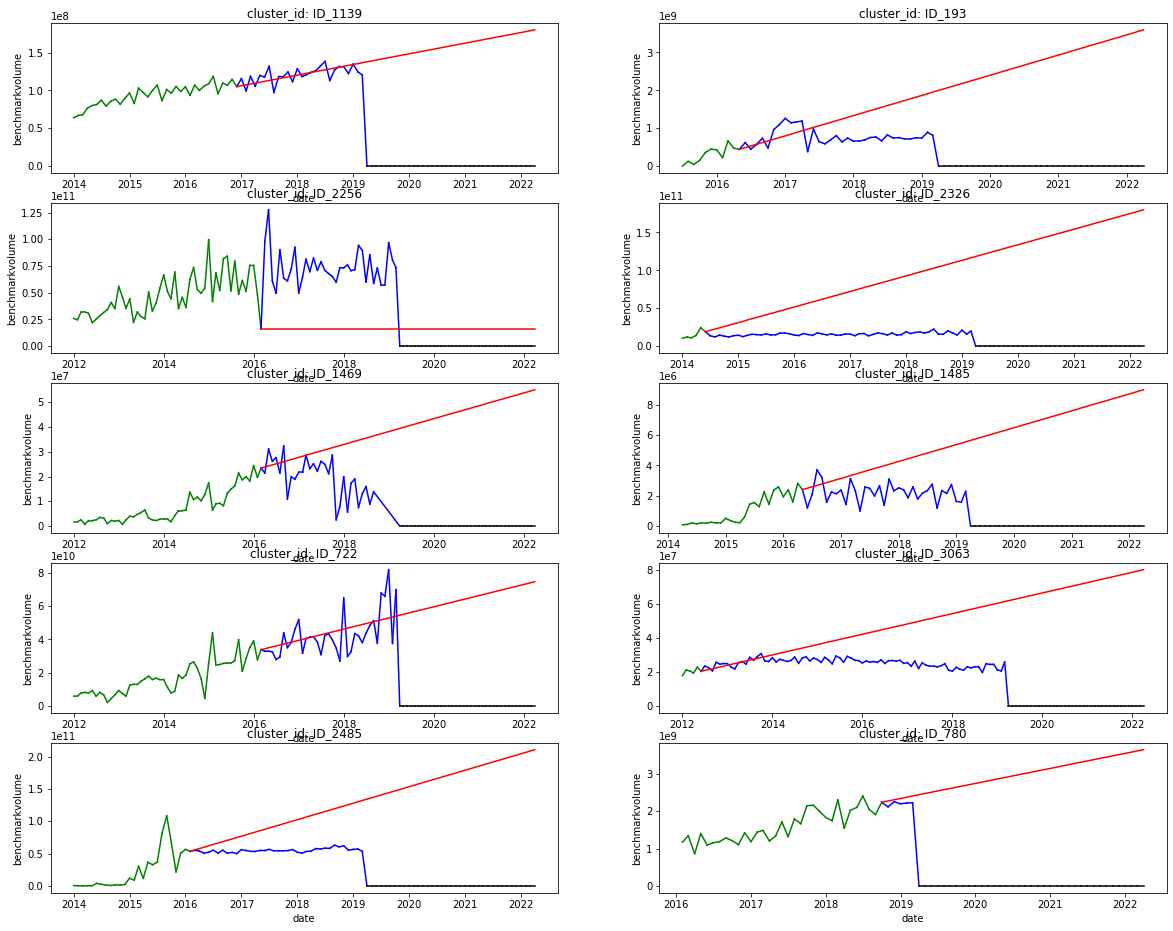

In [ ]:

ids =m_train_df.cluster_id.unique()
fig,axes = plt.subplots(5,2,figsize=(20,16))
print("Growth: Green")
print("Mature: blue")
print("Actural: balck")
print("Predicted: red")
for i in range(10):
    rand = random.randint(0,len(ids))
    cluster = df[df['cluster_id']==ids[rand]].iloc[:,:].reset_index()
    axes.flatten()[i].title.set_text(f'cluster_id: {ids[rand]}')
    predicted = benchmarkgenerate[benchmarkgenerate['cluster_id']==ids[rand]].iloc[:,:]


    # cluster = final_df[final_df['cluster_id']=='ID_40'].iloc[:,[2,3,4,7]].reset_index()
    # axes.flatten()[i].title.set_text(f'cluster_id: ID_40')
    # predicted = benchmark[benchmark['cluster_id']=='ID_40'].iloc[:,[1,2]]

    for idx, row in cluster.iterrows():
      if idx==len(cluster)-1:
          break    
      if row.stage_name =='Growth':
          color = 'green'
      elif row.stage_name =='Maturity':
          color = 'blue'
      else:
          color = 'black' # Stage Name missing
      sns.lineplot(x=[row.date, cluster.loc[idx + 1, 'date']], y=[row.volume, cluster.loc[idx + 1, 'volume']], color=color, ax=axes.flatten()[i])

    sns.lineplot(x='date',y='benchmarkvolume',data=predicted,color='red',ax=axes.flatten()[i])

Growth: Green
Mature: blue
Actural: balck
Predicted: red


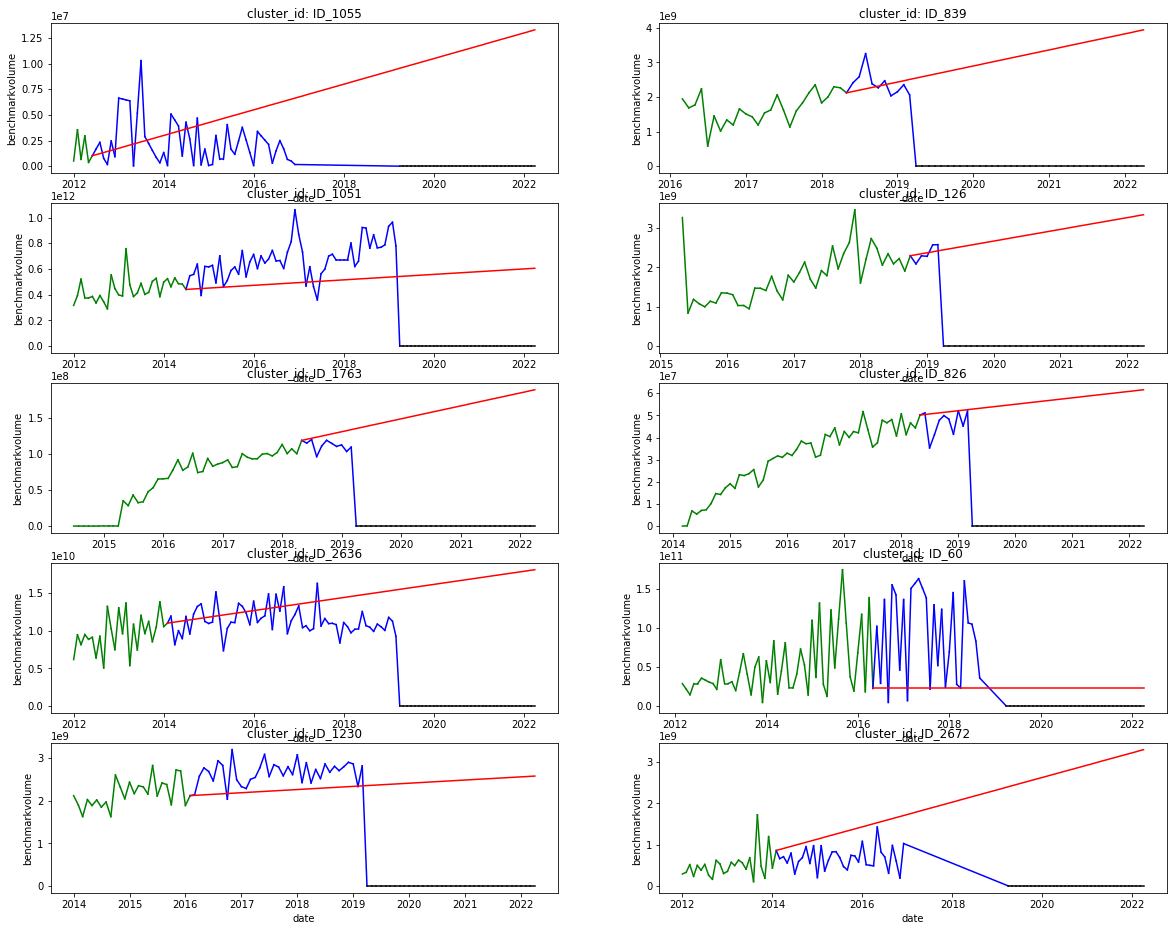

In [ ]:

ids =m_train_df.cluster_id.unique()
fig,axes = plt.subplots(5,2,figsize=(20,16))
print("Growth: Green")
print("Mature: blue")
print("Actural: balck")
print("Predicted: red")
for i in range(10):
    rand = random.randint(0,len(ids))
    cluster = df[df['cluster_id']==ids[rand]].iloc[:,:].reset_index()
    axes.flatten()[i].title.set_text(f'cluster_id: {ids[rand]}')
    predicted = benchmarkgenerate18[benchmarkgenerate18['cluster_id']==ids[rand]].iloc[:,:]


    # cluster = final_df[final_df['cluster_id']=='ID_40'].iloc[:,[2,3,4,7]].reset_index()
    # axes.flatten()[i].title.set_text(f'cluster_id: ID_40')
    # predicted = benchmark[benchmark['cluster_id']=='ID_40'].iloc[:,[1,2]]

    for idx, row in cluster.iterrows():
      if idx==len(cluster)-1:
          break    
      if row.stage_name =='Growth':
          color = 'green'
      elif row.stage_name =='Maturity':
          color = 'blue'
      else:
          color = 'black' # Stage Name missing
      sns.lineplot(x=[row.date, cluster.loc[idx + 1, 'date']], y=[row.volume, cluster.loc[idx + 1, 'volume']], color=color, ax=axes.flatten()[i])

    sns.lineplot(x='date',y='benchmarkvolume',data=predicted,color='red',ax=axes.flatten()[i])

In [ ]:
benchmarkgenerate = pd.merge(benchmarkgenerate,df[['cluster_id','volume','date']], on=['cluster_id','date'],how = 'left')
benchmarkgenerate['diff'] = benchmarkgenerate['volume'] - benchmarkgenerate['benchmarkvolume']

In [ ]:
benchmarkgenerate18 = pd.merge(benchmarkgenerate18,df[['cluster_id','volume','date']], on=['cluster_id','date'],how = 'left')
benchmarkgenerate18['diff'] = benchmarkgenerate18['volume'] - benchmarkgenerate18['benchmarkvolume']

In [ ]:
benchmarkgenerate.head(5)  ## final benchmark dataframe generated using whole data which we need to use for training

date  benchmarkvolume cluster_id        volume          diff
0 2014-02-01     6.128264e+10      ID_18  6.128264e+10  0.000000e+00
1 2014-03-01     6.261583e+10      ID_18  6.223147e+10 -3.843557e+08
2 2014-04-01     6.394902e+10      ID_18  7.129371e+10  7.344697e+09
3 2014-05-01     6.528221e+10      ID_18  8.959621e+10  2.431400e+10
4 2014-06-01     6.661539e+10      ID_18  6.635028e+10 -2.651155e+08

In [ ]:
benchmarkgenerate18.head(5) ## final benchmark dataframe generated using 18 months range data which we need to use for training

date  benchmarkvolume cluster_id        volume          diff
0 2014-02-01     6.128264e+10      ID_18  6.128264e+10  0.000000e+00
1 2014-03-01     6.217551e+10      ID_18  6.223147e+10  5.596027e+07
2 2014-04-01     6.306838e+10      ID_18  7.129371e+10  8.225329e+09
3 2014-05-01     6.396126e+10      ID_18  8.959621e+10  2.563495e+10
4 2014-06-01     6.485413e+10      ID_18  6.635028e+10  1.496148e+09

### train

In [ ]:
benchmarkgenerate
# x_train = training_set.drop(["change_rate"],axis=1)
# y_train = training_set.change_rate

# x_val = val_set.drop(["change_rate"],axis=1)
# y_val = val_set.change_rate

# x_test = test_set.drop(["change_rate"],axis=1)
# y_test = test_set.change_rate

date  benchmarkvolume cluster_id        volume          diff
0     2014-02-01     6.128264e+10      ID_18  6.128264e+10  0.000000e+00
1     2014-03-01     6.261583e+10      ID_18  6.223147e+10 -3.843557e+08
2     2014-04-01     6.394902e+10      ID_18  7.129371e+10  7.344697e+09
3     2014-05-01     6.528221e+10      ID_18  8.959621e+10  2.431400e+10
4     2014-06-01     6.661539e+10      ID_18  6.635028e+10 -2.651155e+08
...          ...              ...        ...           ...           ...
25199 2021-12-01     3.518595e+09     ID_780 -1.000000e+00 -3.518595e+09
25200 2022-01-01     3.552123e+09     ID_780 -1.000000e+00 -3.552123e+09
25201 2022-02-01     3.585650e+09     ID_780 -1.000000e+00 -3.585650e+09
25202 2022-03-01     3.619177e+09     ID_780 -1.000000e+00 -3.619177e+09
25203 2022-04-01     3.652705e+09     ID_780 -1.000000e+00 -3.652705e+09

[25204 rows x 5 columns]

In [ ]:
benchmarkgenerate

date  benchmarkvolume cluster_id        volume          diff
0     2014-02-01     6.128264e+10      ID_18  6.128264e+10  0.000000e+00
1     2014-03-01     6.261583e+10      ID_18  6.223147e+10 -3.843557e+08
2     2014-04-01     6.394902e+10      ID_18  7.129371e+10  7.344697e+09
3     2014-05-01     6.528221e+10      ID_18  8.959621e+10  2.431400e+10
4     2014-06-01     6.661539e+10      ID_18  6.635028e+10 -2.651155e+08
...          ...              ...        ...           ...           ...
25199 2021-12-01     3.518595e+09     ID_780 -1.000000e+00 -3.518595e+09
25200 2022-01-01     3.552123e+09     ID_780 -1.000000e+00 -3.552123e+09
25201 2022-02-01     3.585650e+09     ID_780 -1.000000e+00 -3.585650e+09
25202 2022-03-01     3.619177e+09     ID_780 -1.000000e+00 -3.619177e+09
25203 2022-04-01     3.652705e+09     ID_780 -1.000000e+00 -3.652705e+09

[25204 rows x 5 columns]

In [ ]:
# columns_to_drop=['date', 'cluster_id', 'country', 'cluster', 'cluster_id', 'start_date', 'volume_x', 'volume_y', 'benchmarkvolume', 'stage_name', 'stage_name_lag_1', 'business_unit', 'gx_entry_date', 'launch_date', 'growth_date', 'ther_area_fact']
c_feature = ['country','cluster','cluster_id','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany","year"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth','month_since_GtoM_trans', \
        'prevalence', 'time_since_no_exclusivity', 'population']
benchmarkgenerate_with_features = benchmarkgenerate.merge(df, on = ['date', 'cluster_id'])[n_feature+c_feature+['diff']]
benchmarkgenerate_with_features

indication_num  comp_num  first_comp_month  launch_months  \
0                 0.0         0                -1             66   
1                 0.0         0                -1             67   
2                 0.0         0                -1             68   
3                 0.0         0                -1             69   
4                 0.0         0                -1             70   
...               ...       ...               ...            ...   
23732             0.0         0                -1             70   
23733             0.0         0                -1             71   
23734             0.0         0                -1             72   
23735             0.0         0                -1             73   
23736             0.0         0                -1             74   

       month_since_growth  month_since_GtoM_trans  prevalence  \
0                      25                     1.0  -29.393769   
1                      26                     2.0  -29.393769   
2                      27                     3.0  -29.393769   
3                      28                     4.0  -29.393769   
4                      29                     5.0  -29.393769   
...                   ...                     ...         ...   
23732                  70                     NaN  -29.393769   
23733                  71                     NaN  -29.393769   
23734                  72                     NaN  -29.393769   
23735                  73                     NaN  -29.393769   
23736                  74                     NaN  -29.393769   

       time_since_no_exclusivity  population    country   cluster cluster_id  \
0                            -30   29.393769  country_0  brand_43      ID_18   
1                            -29   29.393769  country_0  brand_43      ID_18   
2                            -28   29.393769  country_0  brand_43      ID_18   
3                            -27   29.393769  country_0  brand_43      ID_18   
4                            -26   29.393769  country_0  brand_43      ID_18   
...                          ...         ...        ...       ...        ...   
23732                        -26   29.393769  country_9  brand_85     ID_780   
23733                        -25   29.393769  country_9  brand_85     ID_780   
23734                        -24   29.393769  country_9  brand_85     ID_780   
23735                        -23   29.393769  country_9  brand_85     ID_780   
23736                        -22   29.393769  country_9  brand_85     ID_780   

      business_unit  ther_area_fact  is_exclusive  month  \
0               TWO               6          True      2   
1               TWO               6          True      3   
2               TWO               6          True      4   
3               TWO               6          True      5   
4               TWO               6          True      6   
...             ...             ...           ...    ...   
23732           ONE              11          True     12   
23733           ONE              11          True      1   
23734           ONE              11          True      2   
23735           ONE              11          True      3   
23736           ONE              11          True      4   

       regulatory_designations_hasany  year          diff  
0                                 1.0  2014  0.000000e+00  
1                                 1.0  2014 -3.843557e+08  
2                                 1.0  2014  7.344697e+09  
3                                 1.0  2014  2.431400e+10  
4                                 1.0  2014 -2.651155e+08  
...                               ...   ...           ...  
23732                             0.0  2021 -3.518595e+09  
23733                             0.0  2022 -3.552123e+09  
23734                             0.0  2022 -3.585650e+09  
23735                             0.0  2022 -3.619177e+09  
23736                             0.0  2022 -3.652705e+09  

[23737

In [ ]:
from sklearn.model_selection import train_test_split

benchmarkgenerate_with_features = benchmarkgenerate_with_features[~benchmarkgenerate_with_features['diff'].isna()]
X = benchmarkgenerate_with_features.drop('diff', axis=1)
y = benchmarkgenerate_with_features['diff']

for col in X.columns[X.isna().any()]:
  X[col] = X[col].fillna(0)

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)

# X = clean_dataset(X)
# X = X[np.isfinite(X).all(1)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train[c_feature]

country    cluster cluster_id business_unit  ther_area_fact  \
8738   country_22  brand_100    ID_1841           ONE               2   
22261   country_7   brand_38     ID_643           ONE               0   
1125    country_1   brand_32     ID_182           TWO              10   
17953  country_38   brand_91    ID_2949           TWO               7   
5388   country_16   brand_92    ID_1441           TWO               7   
...           ...        ...        ...           ...             ...   
8905   country_22    brand_0    ID_1844           ONE               2   
11519  country_27    brand_5    ID_2265           TWO               2   
18296  country_39   brand_90    ID_2784           ONE               5   
2653   country_10  brand_106     ID_839           ONE               2   
10273  country_26   brand_18    ID_2037           ONE               0   

       is_exclusive  month  regulatory_designations_hasany  year  
8738          False      2                             1.0  2022  
22261         False     10                             0.0  2021  
1125           True      7                             0.0  2016  
17953          True      3                             0.0  2017  
5388          False      4                             0.0  2022  
...             ...    ...                             ...   ...  
8905          False      8                             1.0  2021  
11519         False      2                             0.0  2022  
18296         False      2                             0.0  2017  
2653          False      6                             0.0  2018  
10273         False     11                             1.0  2019  

[18989 rows x 9 columns]

In [ ]:
X_train.columns

Index(['indication_num', 'comp_num', 'first_comp_month', 'launch_months',
       'month_since_growth', 'month_since_GtoM_trans', 'prevalence',
       'time_since_no_exclusivity', 'population', 'country', 'cluster',
       'cluster_id', 'business_unit', 'ther_area_fact', 'is_exclusive',
       'month', 'regulatory_designations_hasany', 'year'],
      dtype='object')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

preprocess1 = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),c_feature),
                                      (StandardScaler(),n_feature))

lr_pipe = make_pipeline(preprocess1, LinearRegression())

lr_pipe.fit(X_train,y_train)
print(f'R-sqared for training set is {lr_pipe.score(X_train, y_train)}')

R-sqared for training set is 0.6184349736545305


In [ ]:
print("{:e}".format(mean_squared_error(y_test, lr_pipe.predict(X_test))))
print("{:e}".format(mean_absolute_error(y_test, lr_pipe.predict(X_test))))

3.523418e+22
7.333694e+10


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = make_pipeline(preprocess1, RandomForestRegressor(n_estimators=1000,
 min_samples_split=2,
 min_samples_leaf=1,
 max_features='sqrt',
 max_depth=30,
 bootstrap=False))

rf_pipe.fit(X_train,y_train)
print(f'R-sqared for training set is {rf_pipe.score(X_train, y_train)}')

R-sqared for training set is 0.9993704938363485


In [ ]:
print("{:e}".format(mean_squared_error(y_test, rf_pipe.predict(X_test))))
print("{:e}".format(mean_absolute_error(y_test, rf_pipe.predict(X_test))))

1.722583e+21
1.202821e+10


In [ ]:
mean_absolute_error(y_test, rf_pipe.predict(X_test))/np.mean(y_test)

-0.18881888679881842

### Hyperparemter Tuning (Running takes a long time so just need to include the outputs)

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 50, num = 3)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 4, 8]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [ ]:
# rf = RandomForestRegressor()

# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train, y_train)

In [ ]:
# rf_random.best_params_

In [ ]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy
# base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
# base_model.fit(X_train, y_train)
# base_accuracy = evaluate(base_model, X_test, y_test)

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, X_test, y_test)

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

### Backtesting

In [ ]:
benchmark = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/benchmark_anon.csv")
benchmark = benchmark.drop(columns = {benchmark.columns[0]})
benchmark["date"] = pd.to_datetime(benchmark["date"])

In [ ]:
c_feature = ['country','cluster','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany","year"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months',
             'month_since_growth','x1','x2','x3','x4','vol_mean_alltime','vol_std_alltime',
             'month_since_GtoM_trans','growth_change_rate']

In [ ]:
pred_eval = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/pred_eval.csv")
pred_eval['predicted_date'] = pd.to_datetime(pred_eval.predicted_date)
pred_eval = pred_eval[(pred_eval.is_transition=='YES') & (~pred_eval.predicted_date.isna())] \
.merge(benchmark, left_on=['cluster_id', 'predicted_date'], right_on=['cluster_id', 'date'], how='left') \
[['cluster_id', 'date', 'forecast']].rename({'forecast': 'benchmark'},axis=1)
pred_eval_features = pred_eval.merge(df, on = ['date', 'cluster_id'])[n_feature+c_feature]
pred_eval_features['month_since_GtoM_trans'] = 0
pred_eval_features

indication_num  comp_num  first_comp_month  launch_months  \
0              0.0         0                -1             47   
1              0.0         2              1857             51   
2              0.0         0                -1             55   
3              0.0         0                -1             69   
4              0.0         0                -1            205   
..             ...       ...               ...            ...   
59             0.0         0                -1             56   
60             0.0         5              4595             50   
61             0.0         0                -1             47   
62             1.0         0               -61            118   
63             0.0         0                -1             95   

    month_since_growth         x1         x2        x3         x4  \
0                   47   0.000000   0.000000  0.000000   0.000000   
1                   51   0.000000   0.000000  0.000000   0.000000   
2                   55   0.000000   0.000000  0.000000   0.000000   
3                   68   1.748821   0.000000  0.000000   0.000000   
4                  104  45.700202  31.791333  4.565157  -4.962741   
..                 ...        ...        ...       ...        ...   
59                  56   0.000000   0.000000  0.000000   0.000000   
60                  50   0.000000   0.000000  0.000000   0.000000   
61                  47   0.000000   0.000000  0.000000   0.000000   
62                  44   0.000000   0.000000  0.000000   0.000000   
63                  95  60.825454  -4.718480  2.971769 -28.869338   

    vol_mean_alltime  ...  month_since_GtoM_trans  growth_change_rate  \
0       1.568250e+09  ...                       0           70.142857   
1       3.006491e+06  ...                       0           16.551724   
2       2.142097e+07  ...                       0            1.873182   
3       4.325125e+10  ...                       0         1769.032258   
4       4.022472e+08  ...                       0           18.343305   
..               ...  ...                     ...                 ...   
59      3.272436e+08  ...                       0           57.686850   
60      2.064109e+08  ...                       0           11.135248   
61      8.040329e+09  ...                       0            8.386926   
62      1.499527e+10  ...                       0          756.121549   
63      8.079306e+10  ...                       0           56.616266   

       country    cluster business_unit ther_area_fact  is_exclusive  month  \
0    country_0   brand_56           ONE              0          True      2   
1    country_0   brand_71           ONE              2          True     10   
2    country_2   brand_13           TWO              9          True      8   
3    country_1   brand_27           TWO             10          True     10   
4    country_1  brand_117           TWO              7         False      9   
..         ...        ...           ...            ...           ...    ...   
59  country_42   brand_16           TWO              9          True      3   
60  country_42   brand_13           TWO              9          True      3   
61  country_41   brand_58           ONE              2          True      2   
62  country_34   brand_43           TWO              6         False      9   
63  country_34   brand_36           TWO             10          True      9   

    regulatory_designations_hasany  year  
0                              0.0  2021  
1                              0.0  2020  
2                              0.0  2021  
3                              1.0  2021  
4                              0.0  2020  
..                             ...   ...  
59                             0.0  2021  
60                             1.0  2021  
61                             0.0  2021  
62                             0.0  2020  
63                             0.0  2020  

[64 rows x 21 columns]

In [ ]:
pred_eval['predicted_diff'] = rf_pipe.predict(pred_eval_features)
pred_eval['volume'] = pred_eval['benchmark'] - pred_eval['predicted_diff']
volume_pred = pred_eval[['cluster_id', 'date', 'volume']]

KeyError: ignored

In [ ]:
performance_summary(volume_pred, actual=actual, benchmark = benchmark_selection(generate = False))

In [ ]:
performance_summary(volume_pred, actual=actual, benchmark = benchmark_selection(generate = True))

In [ ]:
x = performance_preprocess(input = volume_pred, actual = actual, benchmark = benchmark_selection(generate = True))
plt_df = x.loc[:,['cluster_id','date','benchmark','outcome','volume']]
viz_df = plt_df.loc[plt_df.cluster_id.isin(volume_pred.cluster_id.unique())]
plot_outcome(viz_df, plt_col=4, n=32)

# prediction performance function (Hang)

## Evaluation Functions 
Input:
* Please make sure the input has the same column names as sub_2
* ['cluster_id', 'date', 'forecast']  
  
Process:  
* If NaN for forecast value, would substitue with benchmark value. 

In [ ]:
from math import log10, floor
actual = validation_2.loc[: , ['cluster_id', 'date', 'volume']]

def performance_preprocess(input = sub_2, actual = actual, benchmark = benchmark):
  col = None
  for i in input.columns:
    if i not in ['cluster_id', 'date'] :
      col = i   
  sub = input.rename(columns = {col:'forecast'})
  benchmark = benchmark.rename(columns = {'forecast':'benchmark'})
  #
  sub.date = pd.to_datetime(sub.date)
  benchmark.date = pd.to_datetime(benchmark.date)
  actual.date = pd.to_datetime(actual.date)
  # add benchmark, 'fcst_volume'
  x = sub.merge(benchmark, on = ['cluster_id', 'date'], how = 'right')
  # substitue NaN with benchmark
  x['outcome'] = x.apply(lambda x: x.forecast if not pd.isna(x.forecast) else x.benchmark, axis = 1)
  # add actual value, 'volume'
  x = x.merge(actual, on = ['cluster_id', 'date'], how = 'inner' )
  x = x.assign(
              err = x.outcome - x.volume,
              is_pred = (~pd.isna(x.forecast)).astype('int32')
            )
  return x

def performance_metrics(input, actual = actual, benchmark = benchmark, verbose = 1):
  def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)
  x = performance_preprocess(input = input, actual = actual, benchmark = benchmark)
  vol_avg = np.mean(x.volume)
  # metrics
  mse = np.mean(x.err ** 2)
  rmse = np.sqrt(mse)
  mae = np.mean(np.abs(x.err))
  pred_pct = x.is_pred.sum() / x.shape[0]
  pred_cluster_id_pct = x.query("is_pred == 1").cluster_id.unique().shape[0] / x.cluster_id.unique().shape[0] 
  #
  if verbose == 1:
    print(f'using average of the actual volume to calculate percentage ({vol_avg:.2e})')
    print(f'MSE: {mse:.2e} ({(100 * mse / (vol_avg**2)) :.2f}%)')
    print(f'RMSE: {rmse:.2e} ({(100 * rmse / vol_avg) :.2f}%)')
    print(f'MAE: {mae:.2e} ({(100 * mae / vol_avg):.2f}%)')
    print(f'pred_pct: {pred_pct * 100:.2f} (Percentage of Prediction by Row Level)')
    print(f'pred_cluster_id_pct: {pred_cluster_id_pct * 100:.2f} (Percentage of Prediction by "cluster_id" Level)')
  return (mse, rmse, mae)

def performance_summary(input, actual = actual, benchmark = benchmark):
  (mse1, rmse1, mae1) = performance_metrics(benchmark, actual, benchmark, verbose = 0)
  (mse, rmse, mae) = performance_metrics(input, actual, benchmark, verbose = 1)
  mse_dif = (mse - mse1) / mse1
  rmse_dif = (rmse - rmse1) / rmse1
  mae_dif = (mae - mae1) / mae1
  print(f'MSE lift: {-mse_dif*100:.2f}%. RMSE lift: {-rmse_dif*100:.2f}%. MAE lift: {-mae_dif*100:.2f}%.')

## Baseline: Benchmark Error

In [ ]:
#performance_summary(sub_2)

## Test Performance

### Generate Benchmark
* make sure df & sub_2 is not changed


In [ ]:
validation_2 = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/submission_part_two.csv")
validation_2 = validation_2.drop(columns = {validation_2.columns[0]})

sub_2 = validation_2.copy()
sub_2['volume'] = sub_2.volume.where(~sub_2.volume.notna(), pd.NaT)
sub_2["date"] = pd.to_datetime(sub_2["date"])

In [ ]:
def benchmark_selection(generate:bool = True, sub_2 = sub_2, df = df):
  if generate:
    benchmarksub2slope = benchmark_func(sub_2,df)
    benchmark = benchmarkwhole(benchmarksub2slope)
    benchmark = benchmark.rename(columns = {'benchmarkvolume':'forecast'})
    benchmark = benchmark.loc[:,['cluster_id','date','forecast']]
  else:
    benchmark = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/data/material_candidates/benchmark_anon.csv")
    benchmark = benchmark.drop(columns = {benchmark.columns[0]})
    benchmark["date"] = pd.to_datetime(benchmark["date"])
  return benchmark

### Random Forest Output

In [ ]:
benchmark = benchmark_selection(generate = True)

#### RF Output Function

Improvement Opportunities:
* growth change rate would change
* disable the prediction to grow

In [ ]:
import datetime
import dateutil.relativedelta
c_feature = ['country','cluster','cluster_id','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany","year"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months',
            'month_since_growth','x1','x2','x3','x4','vol_mean_alltime','vol_std_alltime',
            'month_since_GtoM_trans','growth_change_rate']

def rf_output(model = rfr_pipe1, c_feature = c_feature, n_feature = n_feature, benchmark = benchmark, restrict: bool = False):
  pred_eval = pd.read_csv("https://raw.githubusercontent.com/hangxu0324/Capstone-Project/main/pred_eval.csv")
  pred_eval['predicted_date'] = pd.to_datetime(pred_eval.predicted_date)
  pred_eval['predicted_date_class'] = pred_eval.apply(lambda x: 0 if pd.isna(x.predicted_date) else 1, axis = 1)
  pred_eval['actual_date_class'] = pred_eval.apply(lambda x: 0 if x.is_transition == 'NO' else 1, axis = 1)
  pred_eval = pred_eval.loc[:,['cluster_id','predicted_date','transition_date','is_transition','predicted_date_class','actual_date_class']]
  pred_dates = pred_eval.query("predicted_date_class == 1").loc[:,['cluster_id','predicted_date']]
  pred_df = df.merge(pred_dates, how = "inner", on = "cluster_id").query("date>=predicted_date")
  # Prepare x for prediction
  ## need to compute month_since_GtoM_trans
  pred_df['month_since_GtoM_trans'] = (pred_df.date.dt.month - pred_df.predicted_date.dt.month) + (pred_df.date.dt.year - pred_df.predicted_date.dt.year) * 12 
  ## impute na
  pred_df.regulatory_designations_hasany = pred_df.regulatory_designations_hasany.fillna(-1)
  ## drop
  drop_col = set(pred_df.columns).difference(c_feature + n_feature)
  pred_df_x = pred_df.drop(columns=drop_col)

  # Prediction 
  pred_df_y = rfr_pipe1.predict(pred_df_x)

  # change rate transformation
  pred_df['y_r'] = pred_df_y

  pred_df_y = math.e ** pred_df_y

  pred_df['y'] = pred_df_y

  pred_df.reset_index(drop=True,inplace=True)
  pred_df_x.reset_index(drop=True,inplace=True)

  #
  pred_df = pred_df.sort_values(by = ['cluster_id','date'], ascending = [True, True], ignore_index = True)
  
  for i in range(len(pred_df)):   
      
      try:
          current_row = pred_df.loc[i,:]
          prev_row = pred_df.loc[i-1,:]

          if current_row.cluster_id == prev_row.cluster_id:
              pred_df.at[i,'volume'] = pred_df.loc[i-1,:].pred_vol
              pred_df.at[i,'pred_vol'] = pred_df.loc[i,:].volume * pred_df.loc[i,:].y   
          else:
              pred_df.at[i,'volume'] = benchmark[(benchmark.cluster_id == current_row.cluster_id) & (benchmark.date == current_row.date)].forecast.values[0]
              pred_df.at[i,'pred_vol'] = pred_df.loc[i,:].volume * pred_df.loc[i,:].y
      except:
          continue
  if restrict:
      pred_df = pred_df.merge(benchmark, how='left',on=['cluster_id','date'])
      restrict_id_list = pred_df.groupby(['cluster_id']).y_r.mean().reset_index().query("y_r >= 0.01 | y_r <= 0.01").cluster_id
      first = pred_df.loc[pred_df.cluster_id.isin(restrict_id_list)].groupby('cluster_id').forecast.first().reset_index().rename(columns = {'forecast':'first'})
      pred_df = pred_df.merge(first, how = 'left', on = 'cluster_id')
      pred_df.loc[pred_df.cluster_id.isin(restrict_id_list),'pred_vol'] = pred_df.loc[pred_df.cluster_id.isin(restrict_id_list),'first']
  # final output
  col = ['cluster_id','date','pred_vol']
  pred_sub = pred_df.loc[:,col].rename(columns={'pred_vol':'volume'})

  return pred_sub

#### Execution



##### RF Model Tuning

In [ ]:
train_df,val_df,test_df = train_val_split(df, keep_stage='Maturity')

# filter out average change rate larger than 0
train_df_desc = train_df.groupby("cluster_id").mean()['change_rate'].reset_index()
train_df_desc_cluster = list(train_df_desc[abs(train_df_desc["change_rate"]) <= 0.015].cluster_id)
train_df = train_df[train_df.cluster_id.isin(train_df_desc_cluster)]
print(f'training cluster_id number: {len(train_df_desc_cluster)}')

training cluster_id number: 246


In [ ]:
#Run this chunk to use change rate as label
drop = ["date","stage_name_lag_1","stage_id_cumsum","gx_entry_date","launch_date","start_date","last_stage_days","growth_date",
         #'first_comp_month', 
         'last_ind_days', 'vol_standard','volume',
         'population','prevalence','prevalence_pct', 
         '1','2','3','4','5','6','7','8','9','10','11','12']
drop = set(df.columns).intersection(drop) # Hang Added this line, contact me if have question

training_set = train_df.drop(drop,axis=1)
val_set = val_df.drop(drop, axis=1)
test_set = test_df.drop(drop, axis=1)

x_train = training_set.drop(["change_rate"],axis=1)
y_train = training_set.change_rate

x_val = val_set.drop(["change_rate"],axis=1)
y_val = val_set.change_rate

x_test = test_set.drop(["change_rate"],axis=1)
y_test = test_set.change_rate

In [ ]:
c_feature = ['country','cluster','business_unit','ther_area_fact','is_exclusive','month',"regulatory_designations_hasany","year"]
n_feature = ['indication_num','comp_num','first_comp_month','launch_months','month_since_growth','month_since_GtoM_trans']

preprocess1 = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),c_feature),
                                      (StandardScaler(),n_feature))

rfr_pipe1 = make_pipeline(preprocess1, RandomForestRegressor(
                                  n_estimators = 50,
                                  random_state = 0,
                                  oob_score=True, 
                                  warm_start=True,
                                  n_jobs=-1))

rfr_pipe1.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'cluster',
                                                   'business_unit',
                                                   'ther_area_fact',
                                                   'is_exclusive', 'month',
                                                   'regulatory_designations_hasany',
                                                   'year']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['indication_num', 'comp_num',
                                                   'first_comp_month',
                                                   'launch_months',
                 

In [ ]:
pred_sub = rf_output(model = rfr_pipe1, c_feature = c_feature, n_feature = n_feature, benchmark = benchmark, restrict = True)

##### rnn output adjustment

In [ ]:
df_prediction_adjust = df_prediction.copy(deep=True)
for i in range(len(df_prediction_adjust)):
  id = df_prediction.iloc[i,:]['cluster_id']
  date = pd.to_datetime(df_prediction_adjust.iloc[i,:]['date'])
  volume_benchmark = benchmark.loc[(benchmark.cluster_id==id) & (benchmark.date==date),'forecast'].values[0]
  volume_prediction = df_prediction_adjust.loc[(df_prediction_adjust.cluster_id==id) & (df_prediction_adjust.date==date),'volume'].values[0]
  if volume_benchmark < volume_prediction:
   df_prediction_adjust.loc[(df_prediction_adjust.cluster_id==id) & (df_prediction_adjust.date==date),'volume'] = volume_benchmark

##### results

In [ ]:
pred_sub

cluster_id       date        volume
0      ID_1058 2020-09-01  5.326624e+11
1      ID_1058 2020-10-01  5.326624e+11
2      ID_1058 2020-11-01  5.326624e+11
3      ID_1058 2020-12-01  5.326624e+11
4      ID_1058 2021-01-01  5.326624e+11
..         ...        ...           ...
976     ID_919 2021-12-01  2.164170e+09
977     ID_919 2022-01-01  2.164170e+09
978     ID_919 2022-02-01  2.164170e+09
979     ID_919 2022-03-01  2.164170e+09
980     ID_919 2022-04-01  2.164170e+09

[981 rows x 3 columns]

In [ ]:
#Add MAPE for each cluster_id
performance_summary(pred_sub, actual = actual, benchmark = benchmark_selection(generate = True))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 1.94e+22 (190.45%)
RMSE: 1.39e+11 (138.00%)
MAE: 2.27e+10 (22.54%)
pred_pct: 11.73 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 31.42 (Percentage of Prediction by "cluster_id" Level)
MSE lift: 0.25%. RMSE lift: 0.12%. MAE lift: 0.40%.


In [ ]:
performance_summary(sub_2, actual = actual, benchmark = benchmark_selection(generate = True))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 1.94e+22 (190.91%)
RMSE: 1.39e+11 (138.17%)
MAE: 2.28e+10 (22.63%)
pred_pct: 0.00 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 0.00 (Percentage of Prediction by "cluster_id" Level)
MSE lift: -0.00%. RMSE lift: -0.00%. MAE lift: -0.00%.


In [ ]:
performance_summary(pred_sub, actual = actual, benchmark = benchmark_selection(generate = False))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 3.86e+22 (379.50%)
RMSE: 1.97e+11 (194.81%)
MAE: 2.38e+10 (23.58%)
pred_pct: 11.73 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 31.42 (Percentage of Prediction by "cluster_id" Level)
MSE lift: 0.22%. RMSE lift: 0.11%. MAE lift: 0.53%.


In [ ]:
performance_summary(sub_2, actual = actual, benchmark = benchmark_selection(generate = False))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 3.87e+22 (380.32%)
RMSE: 1.97e+11 (195.02%)
MAE: 2.39e+10 (23.71%)
pred_pct: 0.00 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 0.00 (Percentage of Prediction by "cluster_id" Level)
MSE lift: -0.00%. RMSE lift: -0.00%. MAE lift: -0.00%.


In [ ]:
performance_summary(df_prediction, actual = actual, benchmark = benchmark_selection(generate = False))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 3.93e+22 (386.46%)
RMSE: 1.98e+11 (196.58%)
MAE: 2.55e+10 (25.25%)
pred_pct: 35.14 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 100.00 (Percentage of Prediction by "cluster_id" Level)
MSE lift: -1.61%. RMSE lift: -0.80%. MAE lift: -6.51%.


In [ ]:
performance_summary(df_prediction, actual = actual, benchmark = benchmark_selection(generate = True))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 1.97e+22 (193.70%)
RMSE: 1.40e+11 (139.18%)
MAE: 2.35e+10 (23.28%)
pred_pct: 35.14 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 100.00 (Percentage of Prediction by "cluster_id" Level)
MSE lift: -1.46%. RMSE lift: -0.73%. MAE lift: -2.89%.


In [ ]:
performance_summary(df_prediction_adjust, actual = actual, benchmark = benchmark_selection(generate = False))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 3.93e+22 (386.46%)
RMSE: 1.98e+11 (196.58%)
MAE: 2.55e+10 (25.25%)
pred_pct: 35.14 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 100.00 (Percentage of Prediction by "cluster_id" Level)
MSE lift: -1.61%. RMSE lift: -0.80%. MAE lift: -6.51%.


In [ ]:
performance_summary(df_prediction_adjust, actual = actual, benchmark = benchmark_selection(generate = True))

using average of the actual volume to calculate percentage (1.01e+11)
MSE: 1.97e+22 (193.70%)
RMSE: 1.40e+11 (139.18%)
MAE: 2.35e+10 (23.28%)
pred_pct: 35.14 (Percentage of Prediction by Row Level)
pred_cluster_id_pct: 100.00 (Percentage of Prediction by "cluster_id" Level)
MSE lift: -1.46%. RMSE lift: -0.73%. MAE lift: -2.89%.


#### Visualization

##### Viz Function

In [ ]:
import math
def plot_outcome(plt_df, n=40, plt_col=2):
  print(f'predicted cluster_id: {plt_df.cluster_id.unique().shape[0]}')
  # need fix below (done)
  plt_col = plt_col
  plt_row = math.ceil(n / plt_col)
  fig,axes = plt.subplots(plt_row,plt_col,figsize=(plt_col * 5, plt_row * 3))
  # need dedupte (done)
  id_pool = list(plt_df.cluster_id.unique())
  for i in range(n):
      pick_i = np.random.randint(len(id_pool))
      id = id_pool[pick_i]
      tgt = plt_df[plt_df.cluster_id == id]
      sns.lineplot(x='date',y='volume',data=tgt,ax=axes.flatten()[i],label="Actual")
      sns.lineplot(x='date',y='benchmark',data=tgt,ax=axes.flatten()[i],label="Benchmark")
      sns.lineplot(x='date',y='outcome',data=tgt,ax=axes.flatten()[i],label="Outcome")
      axes.flatten()[i].title.set_text(id)
      id_pool.remove(id)
  fig.tight_layout()

##### Viz Execution

predicted cluster_id: 71


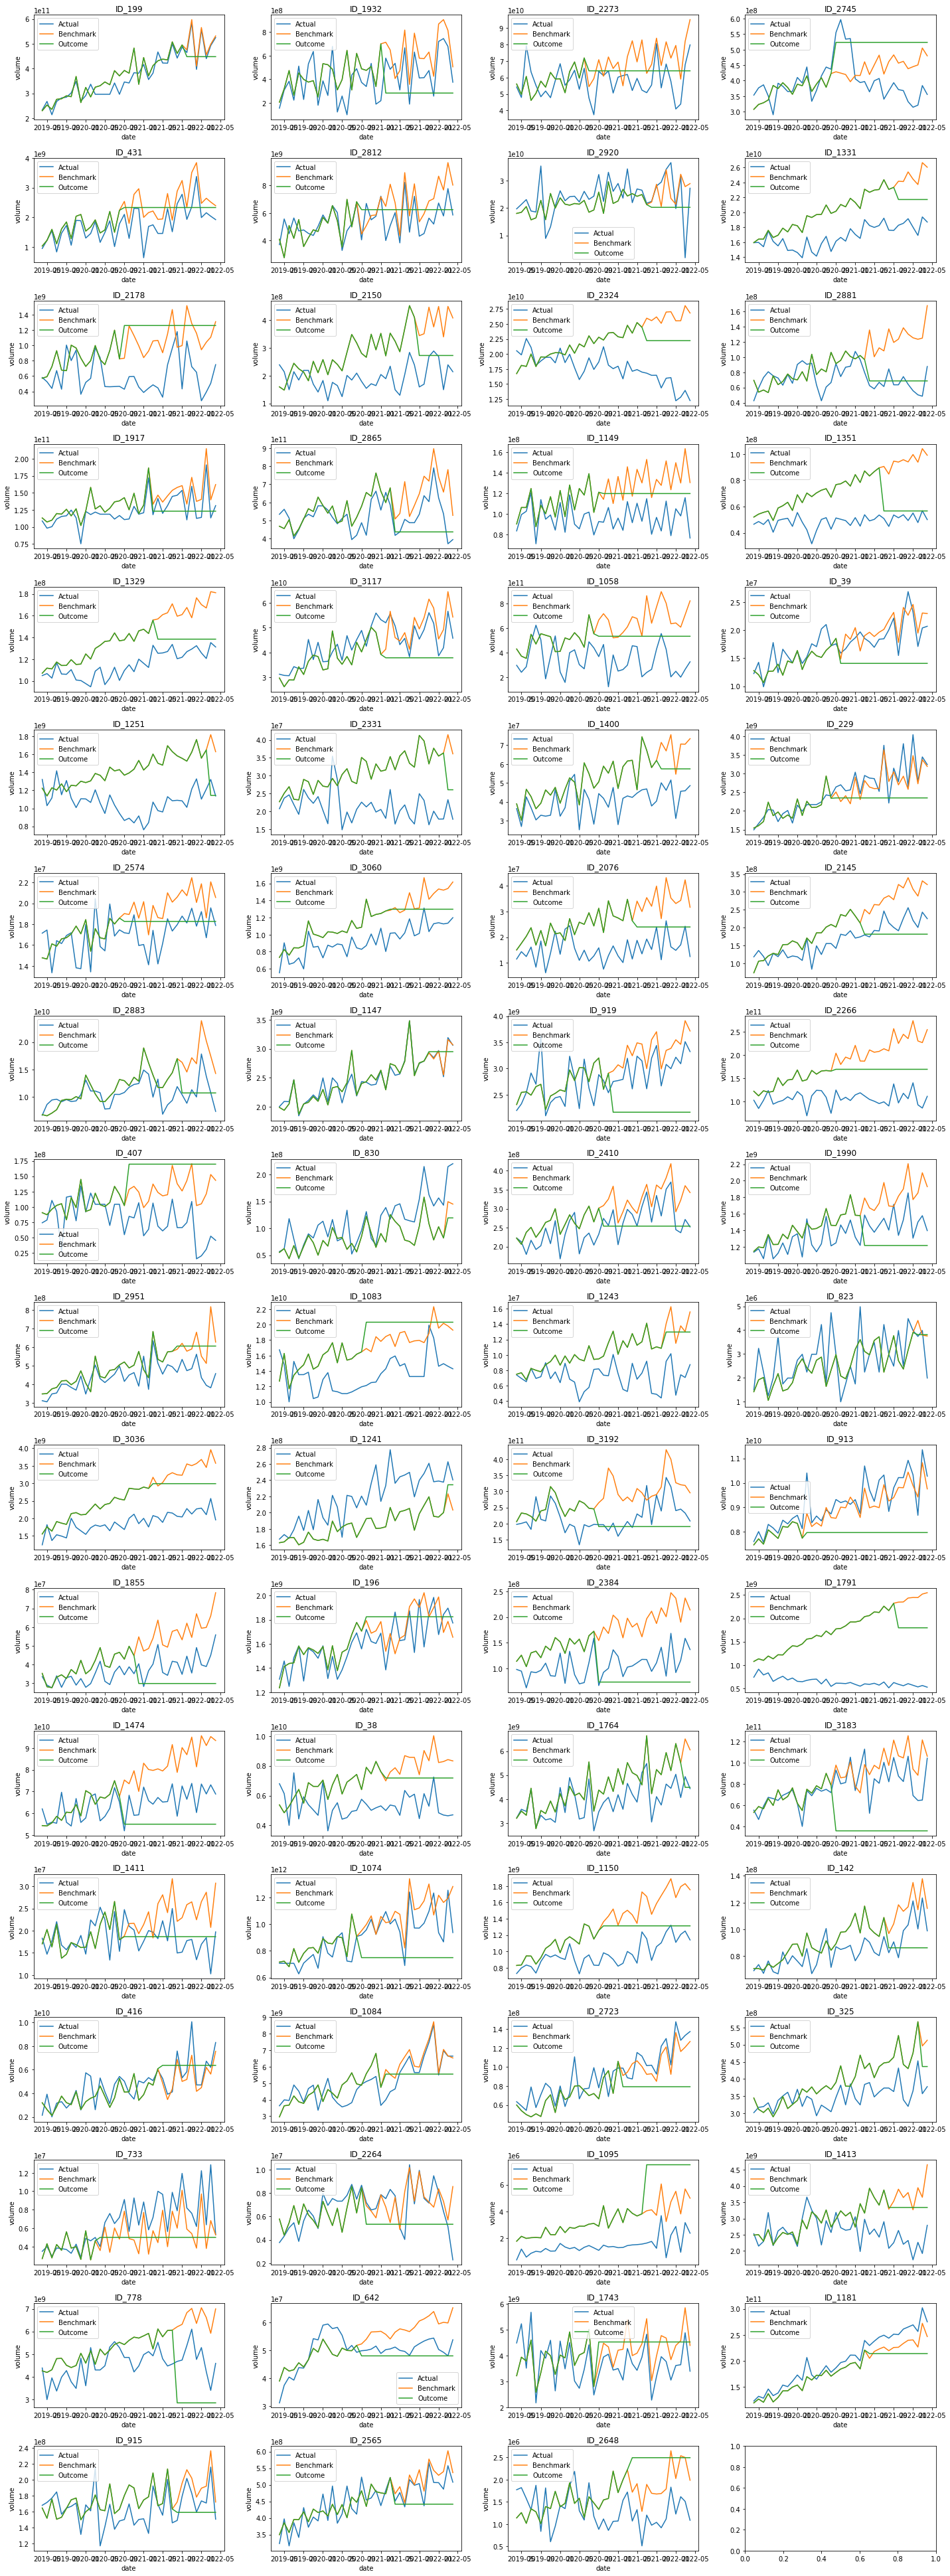

In [ ]:
x = performance_preprocess(input = pred_sub, actual = actual, benchmark = benchmark_selection(generate = False))
plt_df = x.loc[:,['cluster_id','date','benchmark','outcome','volume']]
viz_df = plt_df.loc[plt_df.cluster_id.isin(pred_sub.cluster_id.unique())]
plot_outcome(viz_df, plt_col=4, n=71)

predicted cluster_id: 226


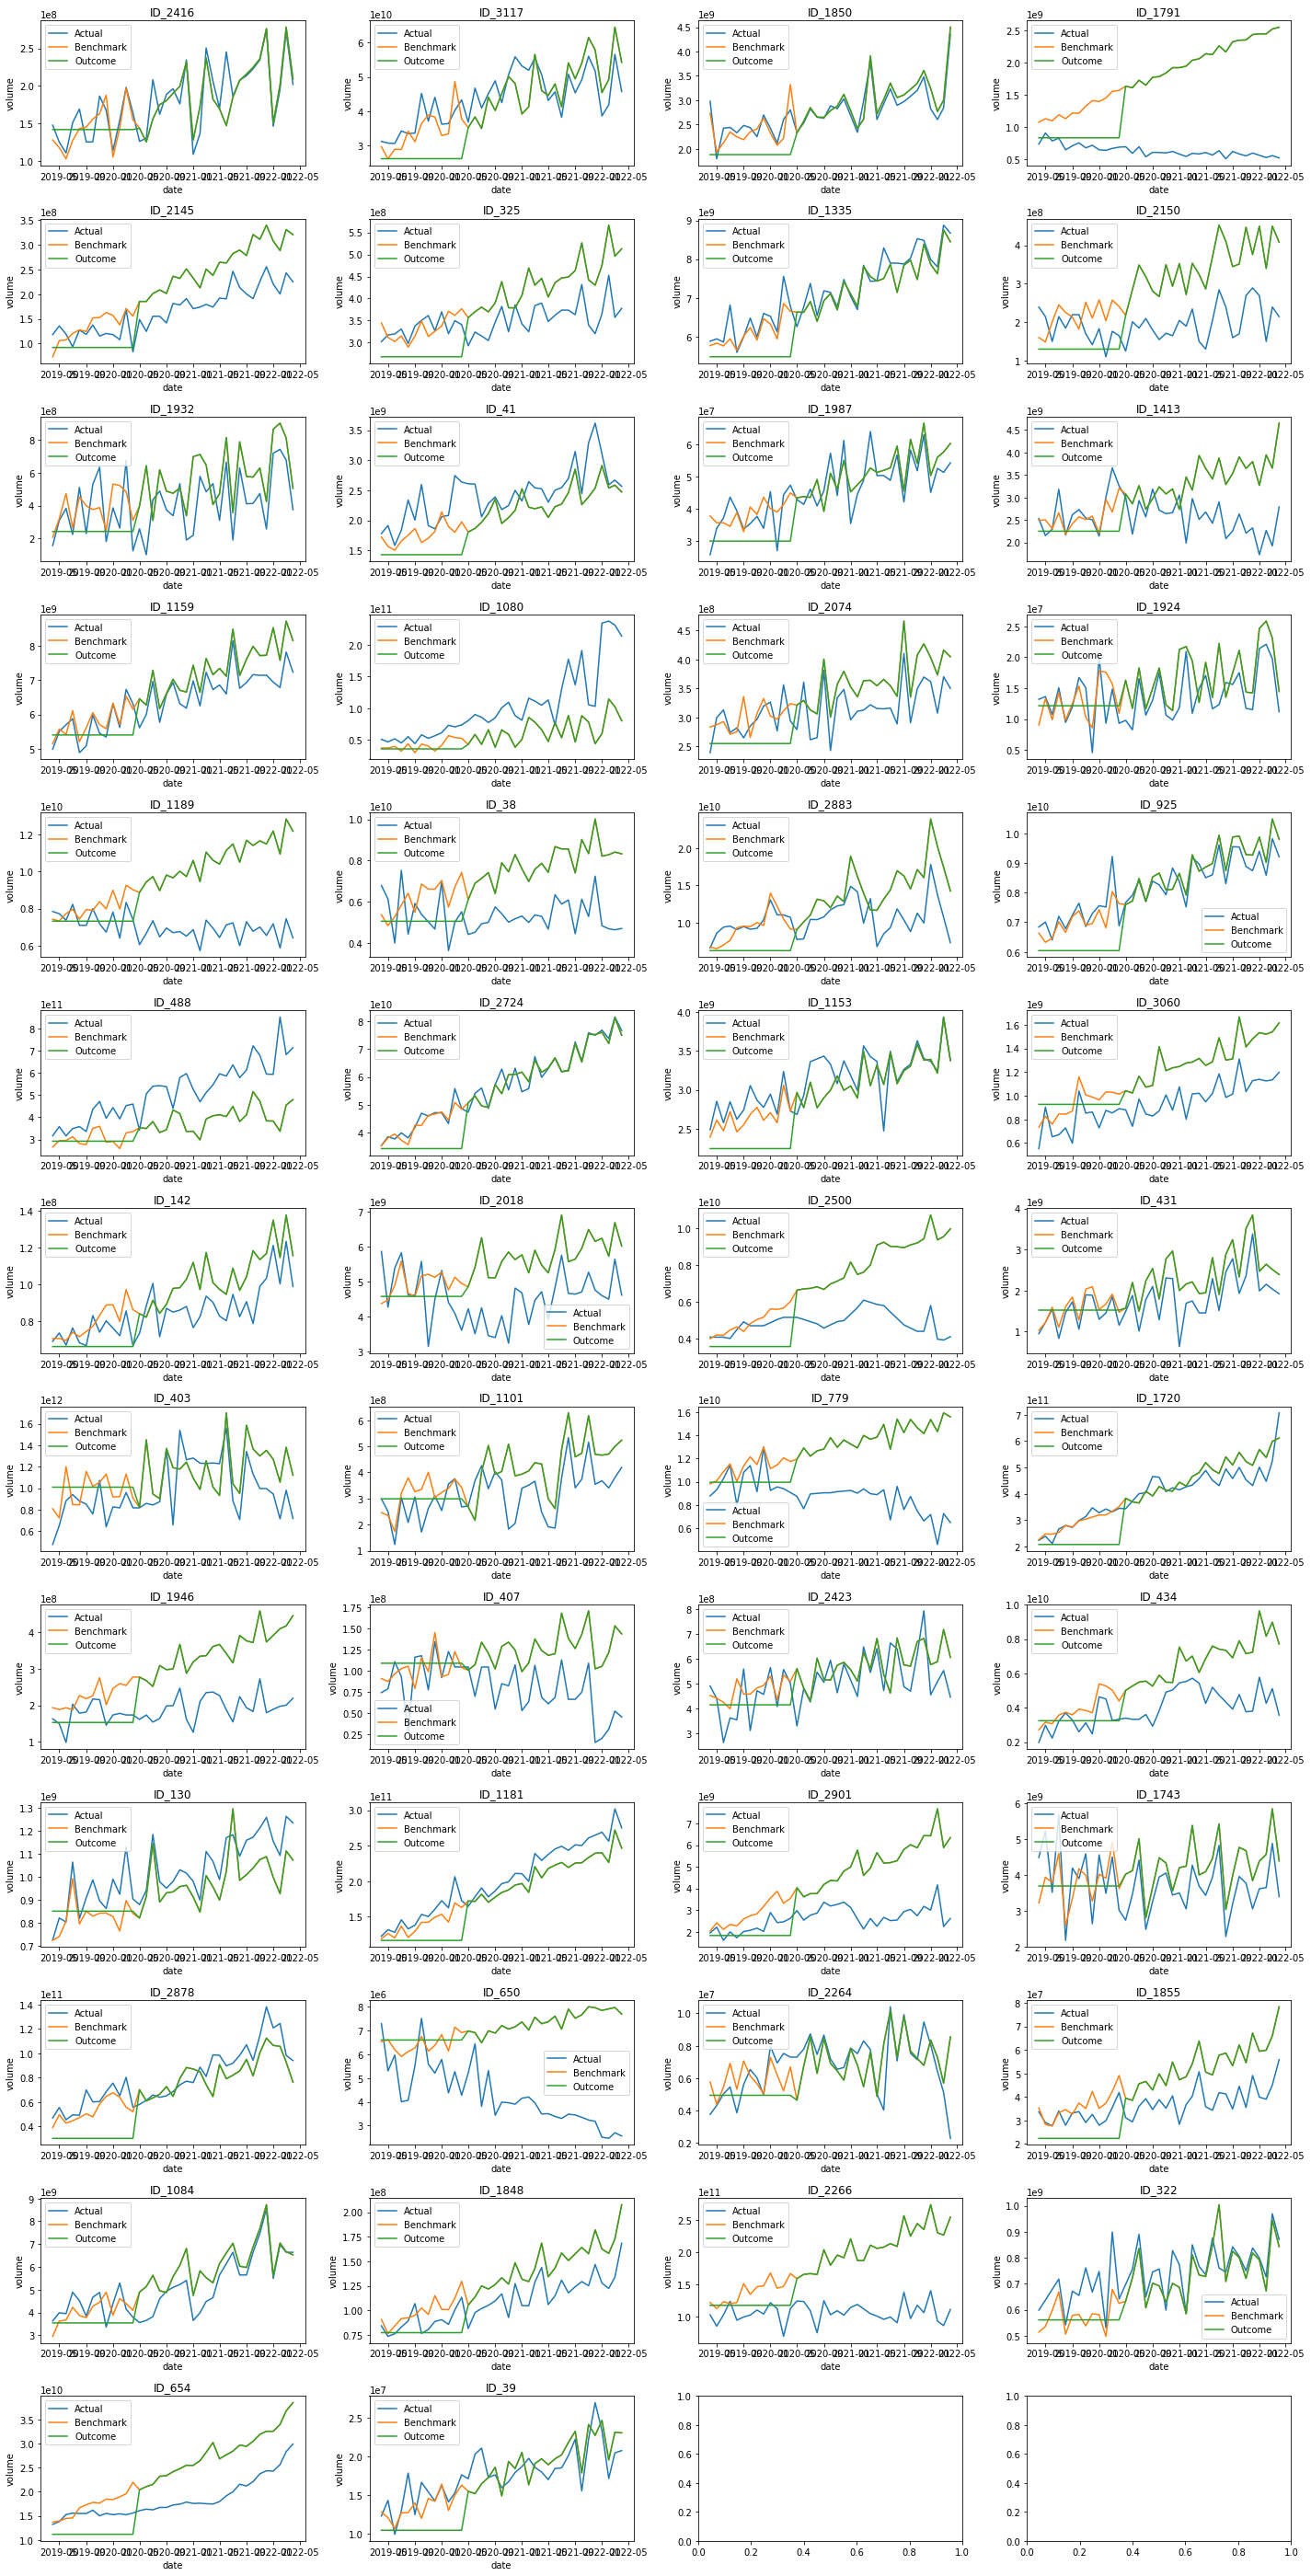

In [ ]:
x = performance_preprocess(input = df_prediction, actual = actual, benchmark = benchmark_selection(generate = False))
plt_df = x.loc[:,['cluster_id','date','benchmark','outcome','volume']]
viz_df = plt_df.loc[plt_df.cluster_id.isin(df_prediction.cluster_id.unique())]
plot_outcome(viz_df, plt_col=4, n=50)

predicted cluster_id: 226


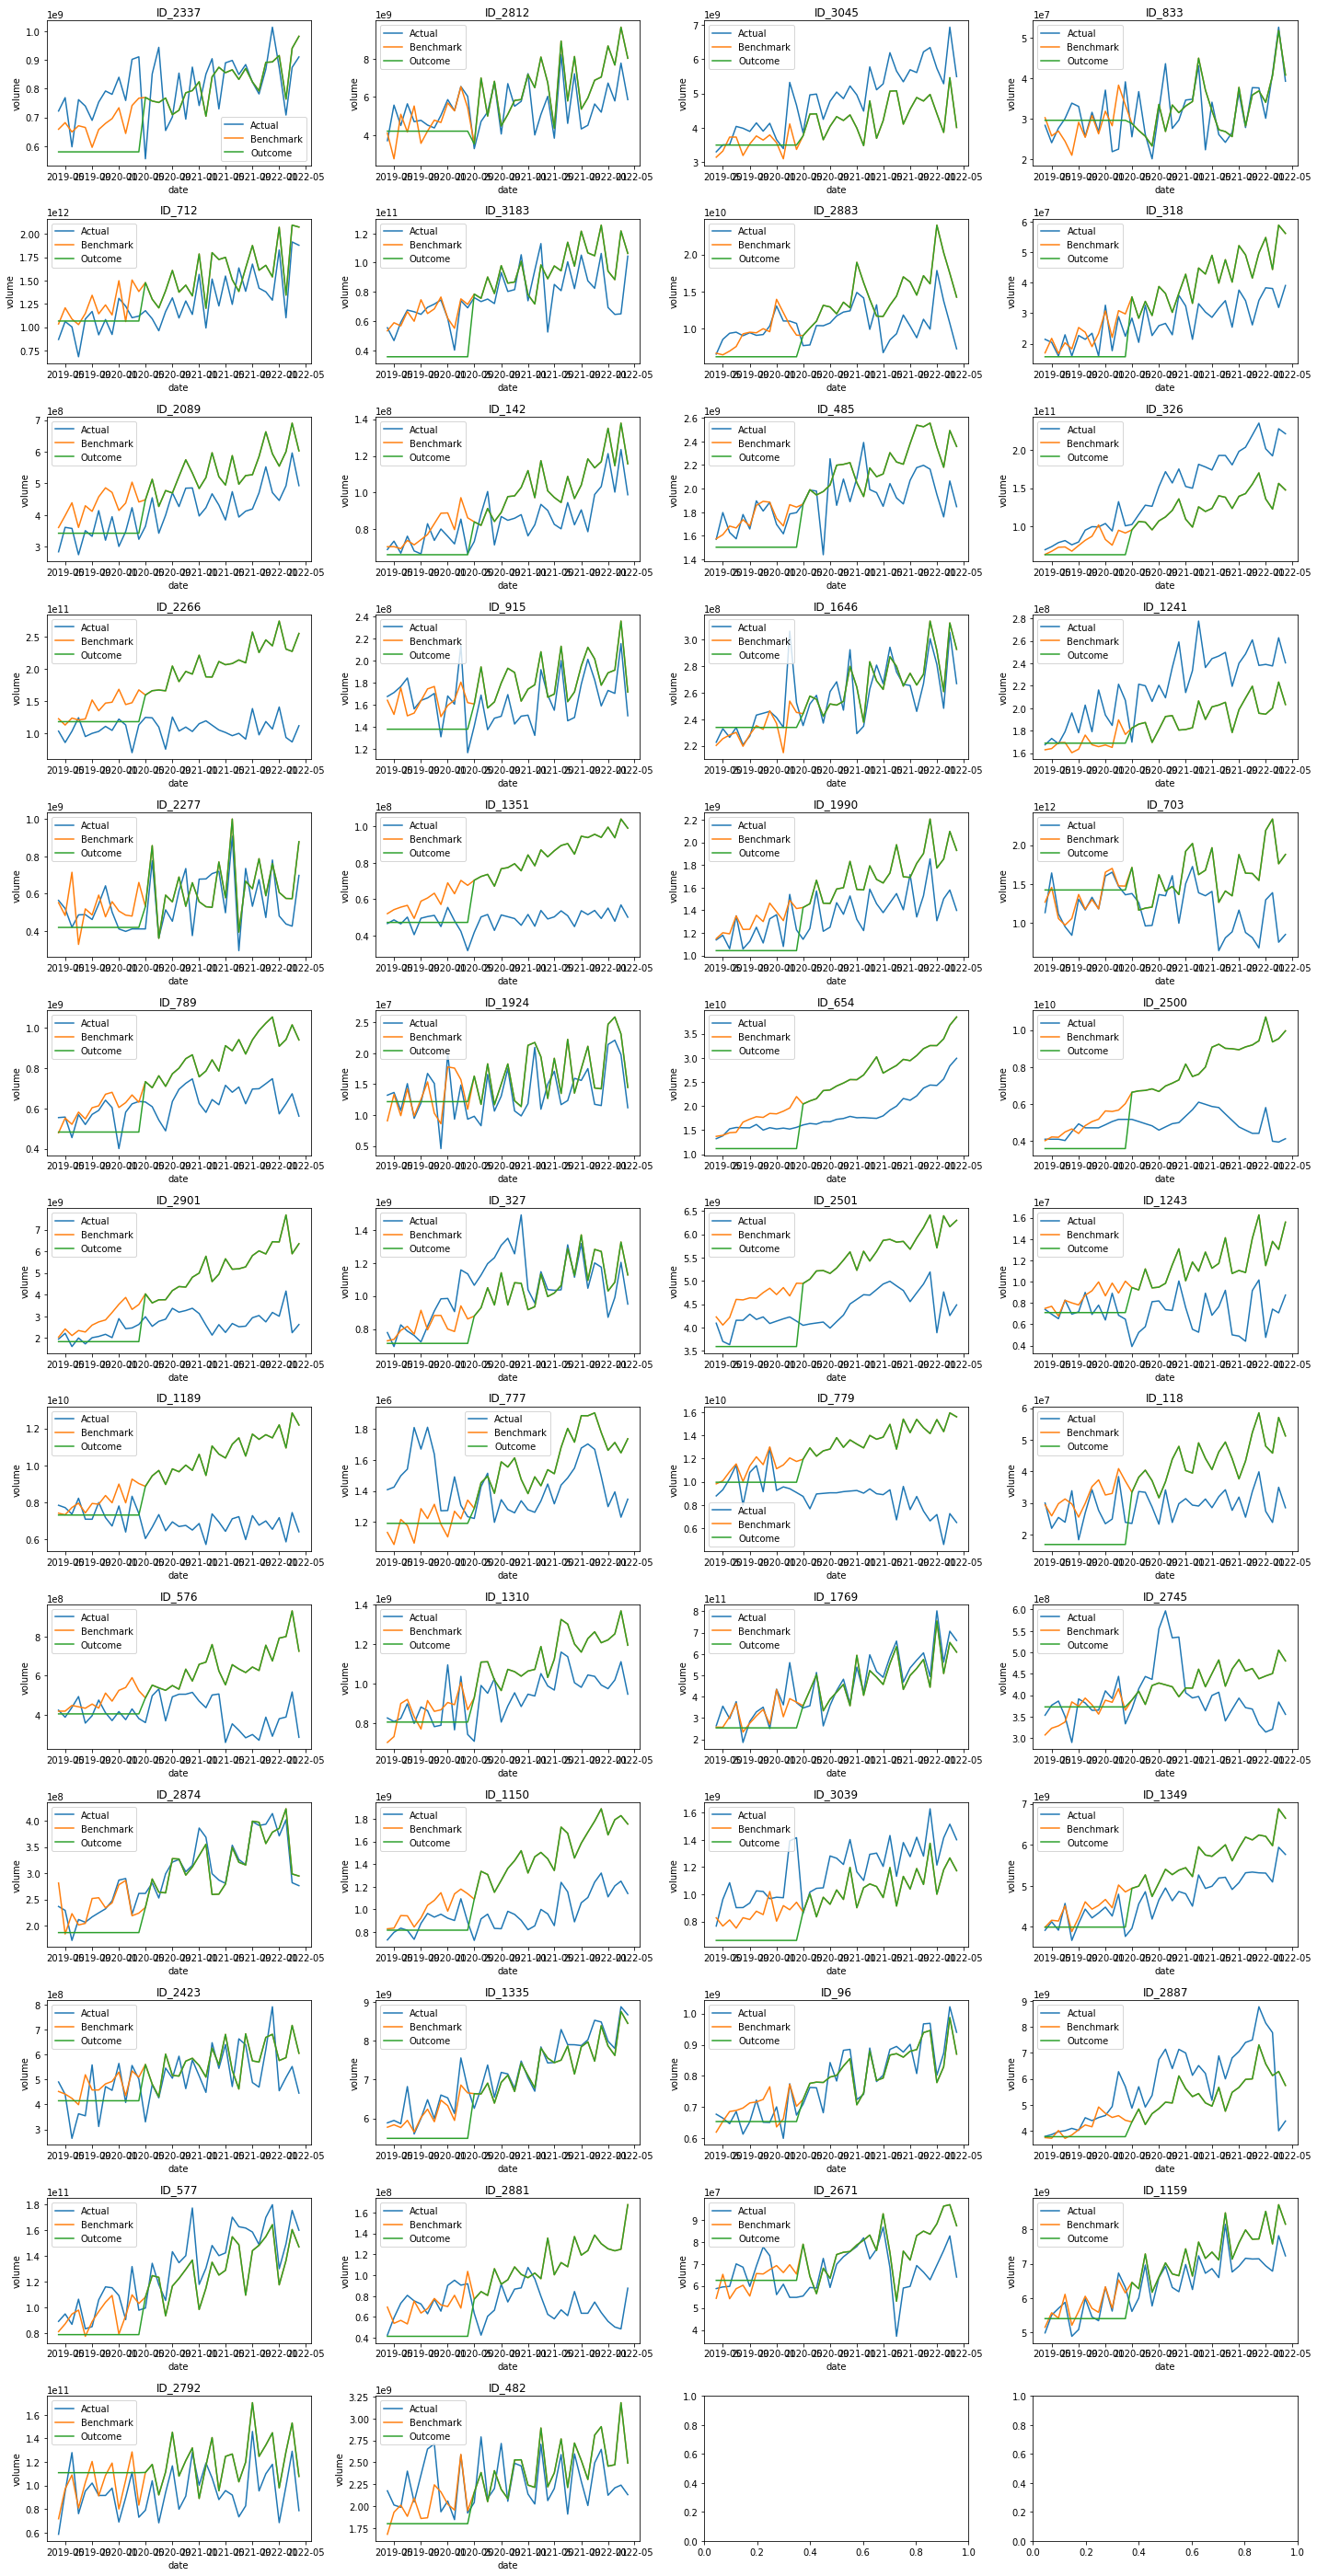

In [ ]:
x = performance_preprocess(input = df_prediction_adjust, actual = actual, benchmark = benchmark_selection(generate = False))
plt_df = x.loc[:,['cluster_id','date','benchmark','outcome','volume']]
viz_df = plt_df.loc[plt_df.cluster_id.isin(df_prediction_adjust.cluster_id.unique())]
plot_outcome(viz_df, plt_col=4, n=50)

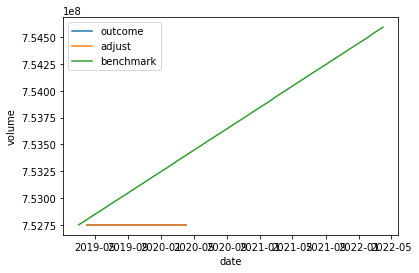

In [ ]:
#df_prediction.query('cluster_id=="ID_1924"')["volume"]
sns.lineplot(x='date',y='volume',data=df_prediction.query('cluster_id=="ID_1669"'),label="outcome")
sns.lineplot(x='date',y='volume',data=df_prediction_adjust.query('cluster_id=="ID_1669"'),label="adjust")
sns.lineplot(x='date',y='forecast',data=benchmark.query('cluster_id=="ID_1669"'),label="benchmark")

In [ ]:
pred_sub.query("cluster_id == 'ID_416'")

cluster_id       date        volume
838     ID_416 2021-05-01  6.366982e+09
839     ID_416 2021-06-01  6.366982e+09
840     ID_416 2021-07-01  6.366982e+09
841     ID_416 2021-08-01  6.366982e+09
842     ID_416 2021-09-01  6.366982e+09
843     ID_416 2021-10-01  6.366982e+09
844     ID_416 2021-11-01  6.366982e+09
845     ID_416 2021-12-01  6.366982e+09
846     ID_416 2022-01-01  6.366982e+09
847     ID_416 2022-02-01  6.366982e+09
848     ID_416 2022-03-01  6.366982e+09
849     ID_416 2022-04-01  6.366982e+09